In [193]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone

In [194]:
start_day_to_analyze = '2020-03-31'
end_day_to_analyze = '2020-04-01'

In [195]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [196]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [197]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [198]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [199]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [205]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price


In [200]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [201]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [203]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


In [190]:

minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=7)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df

In [191]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.01 <= float(item - prev) / prev <= 0.01:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    minute_history_index = minute_history["high"].index.get_loc(now, method='nearest')
    series = minute_history["high"][minute_history_index-200:minute_history_index].dropna().resample("5min").min()
    print(f'current_value={current_value} series = {series.values}')
    diff = np.diff(series.values)
    high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
    if len(high_index) > 0:
        local_maximas = sorted([series[i] for i in high_index if series[i] > current_value])
        print(local_maximas)
        clusters = dict(enumerate(grouper(local_maximas), 1))
        print(clusters)
        resistances = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                resistances.append(round(sum(cluster) / len(cluster), 2))
        resistances = sorted(resistances)
        print (f'resistances={resistances}')
        return resistances

    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    minute_history_index = minute_history["high"].index.get_loc(now, method='nearest')
    series = minute_history["high"][minute_history_index-200:minute_history_index].dropna().resample("5min").min()
    print(f'current_value={current_value} series = {series.values}')
    diff = np.diff(series.values)
    high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
    if len(high_index) > 0:
        local_maximas = sorted([series[i] for i in high_index if series[i] <= current_value])
        print(local_maximas)
        clusters = dict(enumerate(grouper(local_maximas), 1))
        print(clusters)
        supports = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                supports.append(round(sum(cluster) / len(cluster), 2))
        supports = sorted(supports)
        print (f'supports={supports}')
        return supports
    
    return None

current_value=10.35 series = [10.57   10.56   10.65   10.65   10.79   10.75   10.7    10.53   10.4899
 10.47   10.61   10.435  10.46   10.48   10.45   10.401  10.41   10.41
 10.46   10.46   10.498  10.53   10.54   10.52   10.53   10.52   10.67
 10.74   10.7998 10.8102 10.79   10.48   10.53   10.53   10.4436 10.35
 10.265  10.28   10.36   10.43   10.505 ]
[10.41, 10.46, 10.48, 10.53, 10.53, 10.53, 10.54, 10.61, 10.65, 10.79, 10.8102]
{1: [10.41, 10.46, 10.48, 10.53, 10.53, 10.53, 10.54, 10.61, 10.65], 2: [10.79, 10.8102]}
resistances=[10.53, 10.8]
current_value=10.35 series = [10.57   10.56   10.65   10.65   10.79   10.75   10.7    10.53   10.4899
 10.47   10.61   10.435  10.46   10.48   10.45   10.401  10.41   10.41
 10.46   10.46   10.498  10.53   10.54   10.52   10.53   10.52   10.67
 10.74   10.7998 10.8102 10.79   10.48   10.53   10.53   10.4436 10.35
 10.265  10.28   10.36   10.43   10.505 ]
[]
{}
supports=[]
current_value=10.48 series = [10.82   10.79   10.75   10.7    10.53   10

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3208.50,-3208.50,buy,2020-03-30 14:29:16.627031,10.35,[],"[10.53, 10.8]",310,"{'rsi': 76.22507303373018, 'macd': [0.04207120360302952, 0.04217321159221399, 0.04409389350291626, 0.0522756939343445, 0.05809020203379056], 'sell_macd': [0.02241277544809961, 0.022588240362594547, 0.023943300810739032, 0.02936356478577906, 0.033205802106774485], 'slow macd': [0.07482079221925275, 0.07456134744331422, 0.07466881332927677, 0.0760876872798093, 0.07727140507711283], 'macd_signal': [0.04857692934986298, 0.04729618579833318, 0.046655727339249796, 0.047779720658268736, 0.0498418169333731], 'sell_macd_signal': [0.026277258778536632, 0.025539455095348215, 0.02522022423842638, 0.026048892347896917, 0.02748027429967243]}",11.13,10.09
1,34.10,3242.60,sell,2020-03-30 14:41:10.524667,10.46,None,None,310,"{'rsi': 78.0526873320506, 'reasons': 'rsi max', 'movement': 0.011594202898550822, 'sell_macd': [0.035520212958360275, 0.0366716100791713, 0.03891072978267296, 0.040409904489521864, 0.0426117301768123], 'sell_macd_signal': [0.033187650749758935, 0.03388444261564141, 0.03488970004904772, 0.03599374093714255, 0.037317338785076495]}",11.13,10.09
2,-2040.94,-2075.04,buy,2020-03-30 14:43:29.204890,10.48,[10.45],[10.54],198,"{'rsi': 79.80758191542216, 'macd': [0.06330805983981769, 0.06678219016795595, 0.06914189694734674, 0.07339361141043277, 0.07721254882270401], 'sell_macd': [0.0366716100791713, 0.03891072978267296, 0.040409904489521864, 0.04313121069629311, 0.04555390110811075], 'slow macd': [0.07993110191992514, 0.08091662357858098, 0.08177388820962861, 0.083071557287278, 0.08439808680287975], 'macd_signal': [0.05909475899669762, 0.06063224523094928, 0.062334175574228774, 0.06454606274146957, 0.06707935995771645], 'sell_macd_signal': [0.03388444261564141, 0.03488970004904772, 0.03599374093714255, 0.03742123488897266, 0.039047768132800274]}",11.72,10.09
3,32.12,2073.06,sell,2020-03-30 14:43:29.948835,10.47,None,None,198,"{'rsi': 80.73325101725759, 'reasons': 'rsi max', 'movement': 0.00146714174113519, 'sell_macd': [0.03891072978267296, 0.040409904489521864, 0.04313121069629311, 0.04625000500421628, 0.04818348102332237], 'sell_macd_signal': [0.03488970004904772, 0.03599374093714255, 0.03742123488897266, 0.03918698891202138, 0.04098628733428158]}",11.72,10.09
4,-2025.88,-2058.00,buy,2020-03-30 14:44:31.291328,10.50,[10.45],[10.54],196,"{'rsi': 77.29697674502438, 'macd': [0.06914189694734674, 0.07339361141043277, 0.07828149469164991, 0.08002235487275478, 0.08087320139786414], 'sell_macd': [0.040409904489521864, 0.04313121069629311, 0.04625000500421628, 0.04730036414020411, 0.047764275620972185], 'slow macd': [0.08177388820962861, 0.083071557287278, 0.08461240107717316, 0.0856547969013377, 0.08655680953780376], 'macd_signal': [0.062334175574228774, 0.06454606274146957, 0.06729314913150564, 0.06983899027975546, 0.07204583250337719], 'sell_macd_signal': [0.03599374093714255, 0.03742123488897266, 0.03918698891202138, 0.04080966395765793, 0.04220058629032078]}",11.73,10.09
5,32.12,2058.00,sell,2020-03-30 14:44:31.889265,10.50,None,None,196,"{'rsi': 78.9931459493264, 'reasons': 'rsi max', 'movement': 0.002380952380952415, 'sell_macd': [0.040409904489521864, 0.04313121069629311, 0.04625000500421628, 0.04730036414020411, 0.04906297691967154], 'sell_macd_signal': [0.03599374093714255, 0.03742123488897266, 0.03918698891202138, 0.04080966395765793, 0.04246032655006065]}",11.73,10.09
6,-1983.88,-2016.00,buy,2020-03-30 14:44:40.106903,10.50,[10.45],[10.54],192,"{'rsi': 78.00728520832223, 'macd': [0.06914189694734674, 0.07339361141043277, 0.07828149469164991, 0.08002235487275478, 0.08167092219558292], 'sell_macd': [0.040409904489521864, 0.04313121069629311, 0.04625000500421628, 0.04730036414020411, 0.04828375614045122], 'slow macd': [0.08177388820962861, 0.083071557287278, 0.08461240107717316, 0.0856547969013377, 0.08671674556339148], 'macd_signal': [0.062334175574228774, 0.

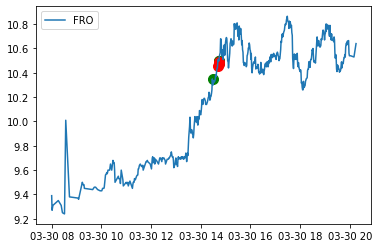

current_value=2.29 series = [2.1709 2.18   2.2    2.2722 2.2816 2.29   2.34   2.34   2.31   2.325
 2.33   2.33   2.31   2.315  2.32   2.33   2.32   2.325  2.33   2.335
 2.33   2.33   2.335  2.3214 2.325  2.3225 2.33   2.3301 2.35   2.37
 2.4299 2.415  2.4    2.465  2.455  2.45   2.46   2.47   2.4742 2.475
 2.475  2.4709 2.465  2.465  2.4425 2.445  2.445  2.445  2.41   2.4
 2.395 ]
[2.325, 2.33, 2.33, 2.33, 2.335, 2.335, 2.34, 2.34, 2.4299, 2.445, 2.445, 2.445, 2.465, 2.465, 2.475, 2.475]
{1: [2.325, 2.33, 2.33, 2.33, 2.335, 2.335, 2.34, 2.34], 2: [2.4299, 2.445, 2.445, 2.445, 2.465, 2.465, 2.475, 2.475]}
resistances=[2.33, 2.46]
current_value=2.29 series = [2.1709 2.18   2.2    2.2722 2.2816 2.29   2.34   2.34   2.31   2.325
 2.33   2.33   2.31   2.315  2.32   2.33   2.32   2.325  2.33   2.335
 2.33   2.33   2.335  2.3214 2.325  2.3225 2.33   2.3301 2.35   2.37
 2.4299 2.415  2.4    2.465  2.455  2.45   2.46   2.47   2.4742 2.475
 2.475  2.4709 2.465  2.465  2.4425 2.445  2.445  2.445 

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1419.80,-1419.80,buy,2020-03-30 14:19:46.966354,2.29,[],"[2.33, 2.46]",620,"{'rsi': 78.40545720088177, 'macd': [0.009126485242178628, 0.011660751502485134, 0.017502005677910493, 0.023474475408765905, 0.027886245421159916], 'sell_macd': [0.005711553524839097, 0.00732692249505984, 0.011087899322568706, 0.014913492963191555, 0.017700793294025186], 'slow macd': [-0.0013117341354016432, -0.0004280174795256997, 0.0011853947936004694, 0.002987761871285244, 0.004641218727849061], 'macd_signal': [0.007276613593901639, 0.008153441175618338, 0.01002315407607677, 0.012713418342614597, 0.01574798375832366], 'sell_macd_signal': [0.004658365447566752, 0.0051920768570653695, 0.0063712413501660365, 0.00807969167277114, 0.01000391199702195]}",2.68,2.16
1,-6.20,1413.60,sell,2020-03-30 14:19:54.815889,2.28,None,None,620,"{'rsi': 78.40545720088177, 'reasons': 'rsi max', 'movement': 0.0, 'sell_macd': [0.005711553524839097, 0.00732692249505984, 0.011087899322568706, 0.014913492963191555, 0.017700793294025186], 'sell_macd_signal': [0.004658365447566752, 0.0051920768570653695, 0.0063712413501660365, 0.00807969167277114, 0.01000391199702195]}",2.68,2.16
2,-1438.04,-1431.84,buy,2020-03-30 14:20:01.559369,2.28,[],"[2.33, 2.46]",628,"{'rsi': 77.70983898628324, 'macd': [0.009126485242178628, 0.011660751502485134, 0.017502005677910493, 0.023474475408765905, 0.02775861009352454], 'sell_macd': [0.005711553524839097, 0.00732692249505984, 0.011087899322568706, 0.014913492963191555, 0.017617676410908167], 'slow macd': [-0.0013117341354016432, -0.0004280174795256997, 0.0011853947936004694, 0.002987761871285244, 0.004615628963755114], 'macd_signal': [0.007276613593901639, 0.008153441175618338, 0.01002315407607677, 0.012713418342614597, 0.015722456692796587], 'sell_macd_signal': [0.004658365447566752, 0.0051920768570653695, 0.0063712413501660365, 0.00807969167277114, 0.009987288620398545]}",2.67,2.16
3,6.36,1444.40,sell,2020-03-30 14:23:49.238965,2.30,None,None,628,"{'rsi': 78.92429700133756, 'reasons': 'rsi max', 'movement': 0.018178640097884922, 'sell_macd': [0.016661832255064013, 0.017807787128535146, 0.018729209275025305, 0.01946370433365363, 0.02238066536201755], 'sell_macd_signal': [0.009796119789229715, 0.011398453257090801, 0.012864604460677703, 0.014184424435272888, 0.01582367262062182]}",2.67,2.16
4,-1160.60,-1166.96,buy,2020-03-30 14:23:59.789265,2.32,[],"[2.33, 2.46]",503,"{'rsi': 77.86414868322402, 'macd': [0.026290803825718356, 0.028197718638707236, 0.029769259091747102, 0.031060132562456655, 0.03491639944050595], 'sell_macd': [0.016661832255064013, 0.017807787128535146, 0.018729209275025305, 0.01946370433365363, 0.02186637964773208], 'slow macd': [0.004321346676669613, 0.005541375965147921, 0.006734947292188043, 0.007902267497845727, 0.009604944316409014], 'macd_signal': [0.01542889543923535, 0.017982660079129728, 0.020339979881653203, 0.022484010417813893, 0.024970488222352306], 'sell_macd_signal': [0.009796119789229715, 0.011398453257090801, 0.012864604460677703, 0.014184424435272888, 0.015720815477764726]}",2.80,2.16
5,21.45,1182.05,sell,2020-03-30 15:02:50.575315,2.35,None,None,503,"{'rsi': 71.23546872795046, 'reasons': 'bail', 'movement': 0.021507693633895115, 'sell_macd': [0.0075367016851108914, 0.007270448543716945, 0.00696855715375122, 0.006902556627105483, 0.008579665870925623], 'sell_macd_signal': [0.01120331188571523, 0.010416739217315573, 0.009727102804602702, 0.009162193569103258, 0.009045688029467732]}",2.80,2.16


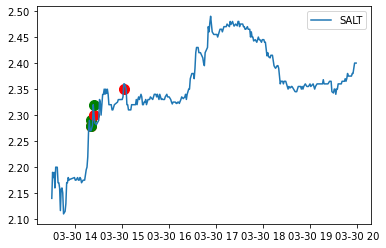

current_value=17.11 series = [17.06   16.65   16.73   16.83   16.75   16.97   16.9    16.75   16.84
 16.84   16.56   16.73   16.58   16.64   16.54   16.55   16.475  16.37
 16.36   16.47   16.55   16.67   16.82   16.76   16.69   16.69   16.6719
 16.72   16.81   16.86   16.81   16.875  16.79   16.85   16.895  16.785
 16.68   16.78   16.79   16.84   16.88   16.85   16.83   16.83   16.75
 16.71   16.65   16.58   16.58  ]
[]
{}
resistances=[]
current_value=17.11 series = [17.06   16.65   16.73   16.83   16.75   16.97   16.9    16.75   16.84
 16.84   16.56   16.73   16.58   16.64   16.54   16.55   16.475  16.37
 16.36   16.47   16.55   16.67   16.82   16.76   16.69   16.69   16.6719
 16.72   16.81   16.86   16.81   16.875  16.79   16.85   16.895  16.785
 16.68   16.78   16.79   16.84   16.88   16.85   16.83   16.83   16.75
 16.71   16.65   16.58   16.58  ]
[16.55, 16.64, 16.69, 16.73, 16.82, 16.83, 16.83, 16.84, 16.84, 16.86, 16.875, 16.88, 16.895, 16.97]
{1: [16.55, 16.64, 16.69, 16.73, 16.

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1437.24,-1437.24,buy,2020-03-30 14:09:19.180375,17.11,[16.8],[],84,"{'rsi': 68.10076647959286, 'macd': [0.19117138234467745, 0.17821911239241217, 0.17401754348517073, 0.18868563002810035, 0.1924434114503022], 'sell_macd': [0.1181600563884544, 0.10908626947268374, 0.10579388655814981, 0.11484145978633009, 0.1167637056811941], 'slow macd': [0.0807373474991202, 0.08306835309483063, 0.08667945683867373, 0.09386155675359831, 0.0991996477880761], 'macd_signal': [0.16852689942218815, 0.17046534201623295, 0.1711757823100205, 0.1746777518536365, 0.17823088377296964], 'sell_macd_signal': [0.10595209974048743, 0.1065789336869267, 0.10642192426117132, 0.10810583136620308, 0.10983740622920128]}",19.96,16.16
1,-32.76,1404.48,sell,2020-03-30 14:43:06.469967,16.72,None,None,84,"{'rsi': 44.59705624696506, 'reasons': 'below cost & macd negative', 'movement': -0.019871420222092335, 'sell_macd': [0.01998892061128288, 0.01727630027205862, 0.012340800004192687, 0.005737282912296138, -0.0010412665477801397], 'sell_macd_signal': [0.028477925715300577, 0.026237600626652185, 0.023458240502160284, 0.019914048984187454, 0.015722985877793937]}",19.96,16.16
2,-2953.44,-2920.68,buy,2020-03-30 14:50:11.988963,17.08,[16.75],[],171,"{'rsi': 62.28819454797523, 'macd': [-0.005327118842430423, -0.01617534791943598, -0.021698315453619443, -0.00543627217751208, 0.016141525513766908], 'sell_macd': [-0.007868171756314268, -0.014644095662230683, -0.017915671489408425, -0.006985527049685913, 0.007336475462430769], 'slow macd': [0.06934495021989306, 0.06533733303098543, 0.062105475180608494, 0.06311110220402227, 0.06569467012567642], 'macd_signal': [0.024711566206207118, 0.016534183381078496, 0.008887683614138907, 0.006022892455808709, 0.008046619067400349], 'sell_macd_signal': [0.011004754350972295, 0.005874984348331699, 0.0011168531807836737, -0.0005036228653102438, 0.001064396800237959]}",18.52,16.64
3,-84.06,2869.38,sell,2020-03-30 14:54:57.589081,16.78,None,None,171,"{'rsi': 44.696188635975545, 'reasons': 'below cost & macd negative', 'movement': -0.021040327293980095, 'sell_macd': [0.008375436501392386, 0.010366116716500784, 0.007626827056629537, 0.004354304892359551, -0.0029275864680116115], 'sell_macd_signal': [0.0012721890080302823, 0.0030909745497243826, 0.003998145051105413, 0.0040693770193562405, 0.00266998432188267]}",18.52,16.64


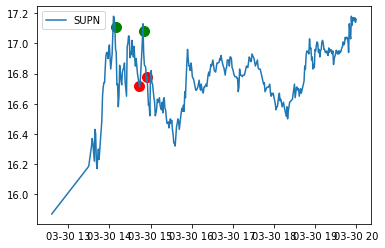

current_value=4.46 series = [4.27   4.28   4.27   4.3    4.33   4.33   4.46   4.519  4.46   4.5
 4.48   4.4    4.5131 4.56   4.6632 4.55   4.6    4.9    4.81   4.87
 4.84   4.79   4.82   4.8324 4.85   4.935  5.04   5.0202 4.875  4.85
 4.86   4.92   4.83   4.815  4.755  4.755  4.91   4.85   4.835  4.81
 4.73   4.69   4.68   4.63   4.635  4.6425 4.56   4.61   4.59   4.565
 4.5    4.47   4.4    4.4   ]
[4.5, 4.519, 4.61, 4.6425, 4.6632, 4.87, 4.9, 4.91, 4.92, 5.04]
{1: [4.5, 4.519], 2: [4.61, 4.6425, 4.6632], 3: [4.87, 4.9, 4.91, 4.92], 4: [5.04]}
resistances=[4.51, 4.64, 4.9]
current_value=4.46 series = [4.27   4.28   4.27   4.3    4.33   4.33   4.46   4.519  4.46   4.5
 4.48   4.4    4.5131 4.56   4.6632 4.55   4.6    4.9    4.81   4.87
 4.84   4.79   4.82   4.8324 4.85   4.935  5.04   5.0202 4.875  4.85
 4.86   4.92   4.83   4.815  4.755  4.755  4.91   4.85   4.835  4.81
 4.73   4.69   4.68   4.63   4.635  4.6425 4.56   4.61   4.59   4.565
 4.5    4.47   4.4    4.4   ]
[4.28, 4.33]
{1:

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1998.08,-1998.08,buy,2020-03-30 14:20:43.360901,4.46,[],"[4.51, 4.64, 4.9]",448,"{'rsi': 68.61789973970245, 'macd': [0.04546909350347761, 0.04497345691467647, 0.04726350281331104, 0.0517099660921474, 0.056997537423518096], 'sell_macd': [0.025270413563986516, 0.024965110905721843, 0.02648091258881813, 0.02939607087968721, 0.032844297198810324], 'slow macd': [0.045122003196161664, 0.04566500408629626, 0.04673129158403899, 0.04827731412141212, 0.0501022995680378], 'macd_signal': [0.05563740870175004, 0.05350461834433533, 0.05225639523813047, 0.052147109408933856, 0.05311719501185071], 'sell_macd_signal': [0.032182466146997844, 0.030738995098742644, 0.02988737859675774, 0.029789117053343632, 0.03040015308243697]}",5.0,4.28
1,-1315.66,682.42,sell,2020-03-30 14:56:39.686732,4.58,None,None,149,"{'rsi': 64.63900321709502, 'reasons': 'scale-out', 'movement': 0.02242152466367705, 'sell_macd': [0.02071074915653881, 0.022245718429844352, 0.02159445139047378, 0.022364964718360802, 0.02423335218530731], 'sell_macd_signal': [0.021896094621201942, 0.021966019382930423, 0.021891705784439094, 0.021986357571223435, 0.02243575649404021]}",5.0,4.28
2,-838.48,477.18,sell,2020-03-30 15:14:22.363447,4.82,None,None,99,"{'rsi': 74.05941031393918, 'reasons': 'scale-out', 'movement': 0.025695931477516084, 'sell_macd': [0.02560712003427401, 0.026498908305240043, 0.02892758866826206, 0.03356126702037976, 0.03933346746332411], 'sell_macd_signal': [0.02873491298773828, 0.028287712051238634, 0.02841568737464332, 0.029444803303790606, 0.03142253613569731]}",5.0,4.28
3,125.52,964.00,sell,2020-03-30 15:14:30.779714,4.82,None,None,200,"{'rsi': 78.21882681566792, 'reasons': 'rsi max', 'movement': 0.018789144050104355, 'sell_macd': [0.02560712003427401, 0.026498908305240043, 0.02892758866826206, 0.03356126702037976, 0.044008792138647834], 'sell_macd_signal': [0.02873491298773828, 0.028287712051238634, 0.02841568737464332, 0.029444803303790606, 0.03235760107076205]}",5.0,4.28


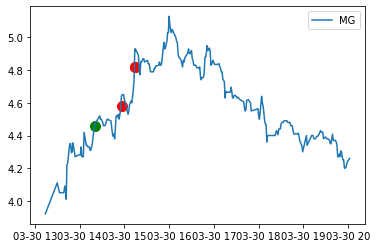

current_value=7.51 series = [7.26   7.25   7.28   7.25   7.31   7.39   7.37   7.36   7.48   7.6488
 7.6519 7.7999 7.71   7.7    7.74   7.77   7.7301 7.78   7.84   7.84
 7.94   7.87   7.87   7.84   7.84   7.78   7.88   7.87   7.88   7.92
 7.84   7.8003 7.88   7.91   7.95   7.94   7.95   7.94   7.925  7.9308
 7.94   7.91   7.81   7.85   7.92   7.91   7.935  7.91   7.89   7.94
 7.9    7.91   7.88   7.87   7.91   7.94   7.9316]
[7.77, 7.7999, 7.84, 7.84, 7.87, 7.88, 7.91, 7.92, 7.92, 7.935, 7.94, 7.94, 7.94, 7.94, 7.95, 7.95]
{1: [7.77, 7.7999, 7.84, 7.84, 7.87, 7.88, 7.91, 7.92, 7.92, 7.935, 7.94, 7.94, 7.94, 7.94, 7.95, 7.95]}
resistances=[7.9]
current_value=7.51 series = [7.26   7.25   7.28   7.25   7.31   7.39   7.37   7.36   7.48   7.6488
 7.6519 7.7999 7.71   7.7    7.74   7.77   7.7301 7.78   7.84   7.84
 7.94   7.87   7.87   7.84   7.84   7.78   7.88   7.87   7.88   7.92
 7.84   7.8003 7.88   7.91   7.95   7.94   7.95   7.94   7.925  7.9308
 7.94   7.91   7.81   7.85   7.92   7.91 

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3184.24,-3184.24,buy,2020-03-30 14:18:08.116645,7.51,[],[7.9],424,"{'rsi': 70.78930341449919, 'macd': [0.029527317139341314, 0.03524384219028853, 0.04171412429926136, 0.04471261741256782, 0.0497432018470656], 'sell_macd': [0.016570072369543, 0.020297275511355295, 0.024496430225606325, 0.02641140233767736, 0.029638505251789127], 'slow macd': [0.02737411032728687, 0.028983206568626407, 0.030897080069244964, 0.032288617296212685, 0.03415697902754822], 'macd_signal': [0.03444787128666941, 0.034607065467393235, 0.036028477233766856, 0.03776530526952705, 0.040160884585034765], 'sell_macd_signal': [0.019944771163683525, 0.02001527203321788, 0.02091150367169557, 0.022011483404891927, 0.02353688777427137]}",8.09,7.33
1,29.68,3213.92,sell,2020-03-30 14:20:34.468643,7.58,None,None,424,"{'rsi': 79.39712047837423, 'reasons': 'rsi max', 'movement': 0.01712765957446809, 'sell_macd': [0.02641140233767736, 0.029119024732309207, 0.03188965225108298, 0.037790275613099666, 0.0439129655625532], 'sell_macd_signal': [0.022011483404891927, 0.023432991670375384, 0.025124323786516904, 0.027657514151833457, 0.030908604433977405]}",8.09,7.33
2,-1524.05,-1553.73,buy,2020-03-30 14:24:39.315997,7.73,[],[7.9],201,"{'rsi': 76.22873821026262, 'macd': [0.07206489548110451, 0.07326085595176224, 0.08134018844641755, 0.08754091688586119, 0.0945923033625089], 'sell_macd': [0.0439129655625532, 0.04453956856780916, 0.04964419988920632, 0.05349658533588908, 0.0578816053549156], 'slow macd': [0.04198512885822847, 0.04379689082785454, 0.04699308304248806, 0.0500184592734767, 0.053361648745851475], 'macd_signal': [0.051713616735912384, 0.056023064579082356, 0.06108648935254939, 0.06637737485921175, 0.07202036055987118], 'sell_macd_signal': [0.030908604433977405, 0.033634797260743754, 0.03683667778643627, 0.040168659296326834, 0.04371124850804459]}",8.93,7.33
3,49.78,1573.83,sell,2020-03-30 15:02:12.631477,7.83,None,None,201,"{'rsi': 66.42925928862364, 'reasons': 'bail', 'movement': 0.02199223803363518, 'sell_macd': [0.013600005011570993, 0.010717571304915907, 0.010410251906159296, 0.013671947804451356, 0.019152854377088246], 'sell_macd_signal': [0.020134456762560662, 0.018251079671031713, 0.01668291411805723, 0.016080720855336055, 0.016695147559686492]}",8.93,7.33


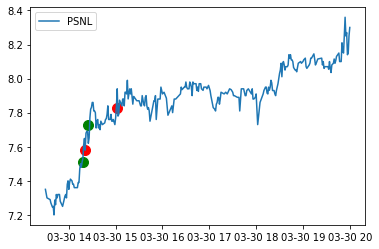

current_value=3.04 series = [2.93   2.9301 2.94   3.02   3.05   3.05   3.17   3.1699 3.12   3.09
 3.12   3.14   3.12   3.13   3.12   3.12   3.1299 3.15   3.14   3.13
 3.12   3.135  3.1123 3.1285 3.12   3.105  3.094  3.08   3.064  3.01
 3.03   3.04   3.0401 3.04   3.04   3.05   3.03   3.045  3.06   3.09
 3.07   3.0189 3.03   3.0399 3.0254 3.025  2.99   3.01   3.0063 3.
 3.    ]
[3.0401, 3.05, 3.05, 3.09, 3.1285, 3.13, 3.135, 3.14, 3.15, 3.17]
{1: [3.0401, 3.05, 3.05], 2: [3.09], 3: [3.1285, 3.13, 3.135, 3.14, 3.15, 3.17]}
resistances=[3.05, 3.14]
current_value=3.04 series = [2.93   2.9301 2.94   3.02   3.05   3.05   3.17   3.1699 3.12   3.09
 3.12   3.14   3.12   3.13   3.12   3.12   3.1299 3.15   3.14   3.13
 3.12   3.135  3.1123 3.1285 3.12   3.105  3.094  3.08   3.064  3.01
 3.03   3.04   3.0401 3.04   3.04   3.05   3.03   3.045  3.06   3.09
 3.07   3.0189 3.03   3.0399 3.0254 3.025  2.99   3.01   3.0063 3.
 3.    ]
[3.01, 3.0399]
{1: [3.01, 3.0399]}
supports=[3.02]
current_value=3.0

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1884.80,-1884.80,buy,2020-03-30 14:51:52.930565,3.04,[3.02],"[3.05, 3.14]",620,"{'rsi': 74.18343007095854, 'macd': [0.012361265208296501, 0.01638126318093569, 0.01935213038820649, 0.021060335403723762, 0.02494271442837448], 'sell_macd': [0.007794165902428762, 0.01037591306111274, 0.012258106781371403, 0.013305814787009762, 0.015762394859104578], 'slow macd': [0.008005343868707993, 0.009033812192495994, 0.009967186988284471, 0.010730012520933752, 0.011972851985364574], 'macd_signal': [0.005476644358010649, 0.007657568122595658, 0.009996480575717824, 0.012209251541319011, 0.014755944118730106], 'sell_macd_signal': [0.003323125502685176, 0.004733683014370689, 0.006238567767770832, 0.007652017171618617, 0.009274092709115809]}",3.44,2.92
1,24.80,1909.60,sell,2020-03-30 14:55:59.964862,3.08,None,None,620,"{'rsi': 79.70307970255, 'reasons': 'rsi max', 'movement': 0.013147972064657792, 'sell_macd': [0.01524810914481911, 0.016464856577594666, 0.0175575837125157, 0.018342077795408862, 0.020891786460060402], 'sell_macd_signal': [0.009171235566258717, 0.010629959768525907, 0.012015484557323866, 0.013280803204940865, 0.014802999855964772]}",3.44,2.92
2,-1574.67,-1599.47,buy,2020-03-30 14:56:32.307986,3.07,[3.03],[3.14],521,"{'rsi': 77.83132888910947, 'macd': [0.024152970838630772, 0.026149161326508352, 0.02796555944291912, 0.02931726099346399, 0.032156146698381516], 'sell_macd': [0.01524810914481911, 0.016464856577594666, 0.0175575837125157, 0.018342077795408862, 0.02009178646006049], 'slow macd': [0.01181451532003086, 0.012763009074305831, 0.01372559687610142, 0.014638836438046976, 0.015879463741639732], 'macd_signal': [0.014597995400781364, 0.016908228585926763, 0.019119694757325233, 0.021159208004552985, 0.02335859574331869], 'sell_macd_signal': [0.009171235566258717, 0.010629959768525907, 0.012015484557323866, 0.013280803204940865, 0.01464299985596479]}",3.54,2.92
3,19.59,1594.26,sell,2020-03-30 14:56:33.446673,3.06,None,None,521,"{'rsi': 78.52572833582806, 'reasons': 'rsi max', 'movement': 0.0017563260261496938, 'sell_macd': [0.016464856577594666, 0.0175575837125157, 0.018342077795408862, 0.020372305940580038, 0.021689726496030293], 'sell_macd_signal': [0.010629959768525907, 0.012015484557323866, 0.013280803204940865, 0.0146991037520687, 0.01609722830086102]}",3.54,2.92


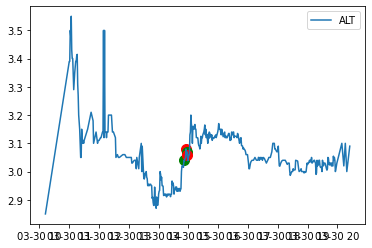

current_value=5.58 series = [5.64   5.555  5.545  5.635  5.65   5.59   5.59   5.6    5.595  5.59
 5.57   5.595  5.5998 5.6    5.675  5.67   5.65   5.645  5.67   5.61
 5.63   5.635  5.65   5.645  5.645  5.65   5.665  5.665  5.665  5.635
 5.655  5.64   5.635  5.635  5.635  5.65   5.635  5.645  5.615  5.615
 5.615 ]
[5.6, 5.615, 5.635, 5.645, 5.65, 5.65, 5.65, 5.655, 5.665, 5.665, 5.665, 5.67, 5.675]
{1: [5.6, 5.615, 5.635, 5.645, 5.65, 5.65, 5.65, 5.655, 5.665, 5.665, 5.665, 5.67, 5.675]}
resistances=[5.65]
current_value=5.58 series = [5.64   5.555  5.545  5.635  5.65   5.59   5.59   5.6    5.595  5.59
 5.57   5.595  5.5998 5.6    5.675  5.67   5.65   5.645  5.67   5.61
 5.63   5.635  5.65   5.645  5.645  5.65   5.665  5.665  5.665  5.635
 5.655  5.64   5.635  5.635  5.635  5.65   5.635  5.645  5.615  5.615
 5.615 ]
[]
{}
supports=[]
LLNW analysis for run 122 with profit 23.28


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1953.00,-1953.00,buy,2020-03-30 14:10:06.153117,5.58,[],[5.65],350,"{'rsi': 70.140622295631, 'macd': [0.022283752293376757, 0.02462873284318068, 0.03057276338398829, 0.03807224299990253, 0.04550833394684606], 'sell_macd': [0.01323887245712907, 0.01472819564262906, 0.018554574804802826, 0.023373122531110013, 0.02812298929795798], 'slow macd': [0.01325622580987762, 0.01422492493336236, 0.01597305647410785, 0.01819559084010436, 0.020611132308636648], 'macd_signal': [0.02065164866184474, 0.021447065498111928, 0.0232722050752872, 0.026232212660210266, 0.030087436917537423], 'sell_macd_signal': [0.012374499341056663, 0.012845238601371142, 0.013987105842057479, 0.015864309179867985, 0.018316045203485985]}",6.27,5.35
1,-1291.80,661.20,sell,2020-03-30 14:17:06.388392,5.70,None,None,116,"{'rsi': 75.1469359838904, 'reasons': 'scale-out', 'movement': 0.02150537634408604, 'sell_macd': [0.03544743798759864, 0.035355548686831106, 0.037941666781208916, 0.04154199689655247, 0.04536638403972226], 'sell_macd_signal': [0.025718974404866556, 0.027646289261259466, 0.029705364765249355, 0.032072691191509975, 0.034731429761152434]}",6.27,5.35
2,23.28,1315.08,sell,2020-03-30 14:49:49.583036,5.62,None,None,234,"{'rsi': 43.94120093562049, 'reasons': 'below cost & macd negative', 'movement': -0.013157894736842136, 'sell_macd': [0.007982024192962456, 0.005835816478684919, 0.0038279167470571807, 0.0019538660893330118, -5.128852823510499e-05], 'sell_macd_signal': [0.015211206868624974, 0.013336128790636963, 0.011434486381921006, 0.009538362323403406, 0.007620432153075704]}",6.27,5.35


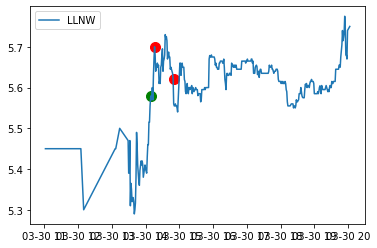

current_value=7.39 series = [7.55  7.48  7.46  7.47  7.565 7.63  7.67  7.7   7.7   7.62  7.59  7.63
 7.67  7.64  7.7   7.7   7.63  7.63  7.68  7.67  7.66  7.72  7.765 7.775
 7.87  7.86  7.86  7.775 7.71  7.73  7.79  7.82  7.85  7.825 7.77  7.7
 7.68  7.685 7.62  7.62  7.64  7.63  7.6   7.58 ]
[7.64, 7.67, 7.68, 7.685, 7.7, 7.7, 7.7, 7.7, 7.85, 7.86, 7.87]
{1: [7.64, 7.67, 7.68, 7.685, 7.7, 7.7, 7.7, 7.7], 2: [7.85, 7.86, 7.87]}
resistances=[7.68, 7.86]
current_value=7.39 series = [7.55  7.48  7.46  7.47  7.565 7.63  7.67  7.7   7.7   7.62  7.59  7.63
 7.67  7.64  7.7   7.7   7.63  7.63  7.68  7.67  7.66  7.72  7.765 7.775
 7.87  7.86  7.86  7.775 7.71  7.73  7.79  7.82  7.85  7.825 7.77  7.7
 7.68  7.685 7.62  7.62  7.64  7.63  7.6   7.58 ]
[]
{}
supports=[]
AKBA analysis for run 122 with profit 91.28


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2379.58,-2379.58,buy,2020-03-30 14:21:20.901179,7.39,[],"[7.68, 7.86]",322,"{'rsi': 65.24962172546277, 'macd': [0.029614340603857592, 0.038492345762272784, 0.046205969795078516, 0.05052626247268943, 0.056526192491071825], 'sell_macd': [0.018500049766233317, 0.02416862664558561, 0.029051042049683673, 0.03169901454573765, 0.03542861630180916], 'slow macd': [0.006004685703662638, 0.00871294910004039, 0.01143060694836695, 0.013672753402268256, 0.0163534763038351], 'macd_signal': [0.02442509443515655, 0.0272385447005798, 0.03103202971947954, 0.03493087627012152, 0.039249939514311584], 'sell_macd_signal': [0.015616195206275487, 0.017326681494137512, 0.019671553605246743, 0.022077045793344924, 0.02474735989503777]}",8.18,7.18
1,-1568.52,811.06,sell,2020-03-30 14:49:24.015154,7.58,None,None,107,"{'rsi': 67.89563233172417, 'reasons': 'scale-out', 'movement': 0.020188425302826427, 'sell_macd': [0.03277432296604399, 0.031542951689072396, 0.03069327339936656, 0.030671533519084804, 0.03181470330692804], 'sell_macd_signal': [0.028137637446359227, 0.028818700294901863, 0.0291936149157948, 0.0294891986364528, 0.02995429957054785]}",8.18,7.18
2,91.28,1659.80,sell,2020-03-30 15:21:26.072335,7.72,None,None,215,"{'rsi': 71.32783501986842, 'reasons': 'bail', 'movement': 0.021108179419525086, 'sell_macd': [0.02809105966063985, 0.027162778681955047, 0.02686590027412361, 0.027324619693033014, 0.029405120283182207], 'sell_macd_signal': [0.025949508279331727, 0.026192162359856393, 0.026326909942709836, 0.026526451892774472, 0.02710218557085602]}",8.18,7.18


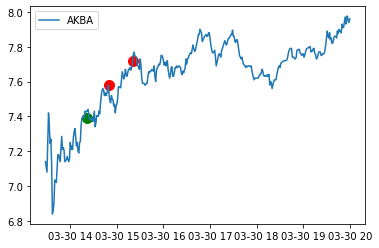

current_value=6.28 series = [6.23  6.255 6.34  6.41  6.37  6.36  6.38  6.375 6.33  6.31  6.355 6.36
 6.34  6.315 6.31  6.325 6.345 6.34  6.31  6.26  6.21  6.2   6.18  6.16
 6.18  6.2   6.19  6.16  6.14  6.15  6.165 6.16  6.22  6.21  6.185 6.215
 6.19  6.165 6.18  6.18  6.16  6.19  6.2  ]
[6.345, 6.36, 6.38, 6.41]
{1: [6.345, 6.36, 6.38, 6.41]}
resistances=[6.37]
current_value=6.28 series = [6.23  6.255 6.34  6.41  6.37  6.36  6.38  6.375 6.33  6.31  6.355 6.36
 6.34  6.315 6.31  6.325 6.345 6.34  6.31  6.26  6.21  6.2   6.18  6.16
 6.18  6.2   6.19  6.16  6.14  6.15  6.165 6.16  6.22  6.21  6.185 6.215
 6.19  6.165 6.18  6.18  6.16  6.19  6.2  ]
[6.165, 6.18, 6.18, 6.2, 6.215, 6.22]
{1: [6.165, 6.18, 6.18, 6.2, 6.215, 6.22]}
supports=[6.19]
SPWH analysis for run 122 with profit 58.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2298.48,-2298.48,buy,2020-03-30 14:25:12.591368,6.28,[6.19],[6.37],366,"{'rsi': 66.86033322036067, 'macd': [0.029683973638527483, 0.028077917195512114, 0.03128595938750234, 0.03380979917453164, 0.03819389246437499], 'sell_macd': [0.016974921776903074, 0.015930779648416937, 0.018027152280136072, 0.01966553157394202, 0.022504976068154825], 'slow macd': [0.028482216613767264, 0.02856651800335719, 0.02955800597834113, 0.030496503302021694, 0.03187095205395263], 'macd_signal': [0.027745581446031446, 0.02781204859592758, 0.028506830754242533, 0.029567424438300356, 0.031292718043515286], 'sell_macd_signal': [0.015732517295014153, 0.01577216976569471, 0.016223166268582983, 0.01691163932965479, 0.018030306677354797]}",6.94,6.06
1,-1515.24,783.24,sell,2020-03-30 15:04:18.162022,6.42,None,None,122,"{'rsi': 75.83776724825445, 'reasons': 'scale-out', 'movement': 0.022292993630573195, 'sell_macd': [0.011994917183567821, 0.015765862747550763, 0.02005795198250393, 0.022622463698279027, 0.026404908363840462], 'sell_macd_signal': [0.006455892208952802, 0.008317886316672393, 0.0106658994498387, 0.013057212299526767, 0.015726751512389506]}",6.94,6.06
2,58.56,1573.80,sell,2020-03-30 15:06:40.256767,6.45,None,None,244,"{'rsi': 78.02710796305767, 'reasons': 'rsi max', 'movement': 0.0038940809968847907, 'sell_macd': [0.02005795198250393, 0.022622463698279027, 0.026404908363840462, 0.029398957345266652, 0.03225926879384211], 'sell_macd_signal': [0.0106658994498387, 0.013057212299526767, 0.015726751512389506, 0.018461192678964934, 0.02122080790194037]}",6.94,6.06


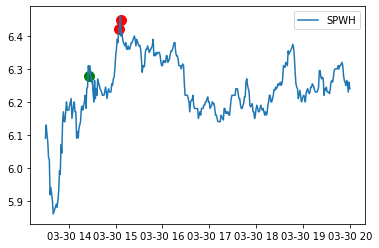

current_value=2.34 series = [2.24   2.21   2.21   2.217  2.22   2.2499 2.22   2.22   2.24   2.2692
 2.28   2.315  2.33   2.295  2.285  2.285  2.2759 2.27   2.23   2.2401
 2.2508 2.263  2.27   2.28   2.2999 2.3    2.29   2.285  2.291  2.3
 2.2827 2.2875 2.2799 2.28   2.27   2.275  2.28   2.28   2.285  2.3301
 2.35   2.46  ]
[]
{}
resistances=[]
current_value=2.34 series = [2.24   2.21   2.21   2.217  2.22   2.2499 2.22   2.22   2.24   2.2692
 2.28   2.315  2.33   2.295  2.285  2.285  2.2759 2.27   2.23   2.2401
 2.2508 2.263  2.27   2.28   2.2999 2.3    2.29   2.285  2.291  2.3
 2.2827 2.2875 2.2799 2.28   2.27   2.275  2.28   2.28   2.285  2.3301
 2.35   2.46  ]
[2.2499, 2.28, 2.28, 2.285, 2.2875, 2.3, 2.3, 2.33]
{1: [2.2499], 2: [2.28, 2.28, 2.285, 2.2875, 2.3, 2.3], 3: [2.33]}
supports=[2.29]
ATHX analysis for run 122 with profit -36.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2358.72,-2358.72,buy,2020-03-30 14:16:17.502558,2.34,[2.29],[],1008,"{'rsi': 67.71277822852166, 'macd': [0.022974447960852018, 0.021743228106248846, 0.0221182754782121, 0.024553218285554124, 0.026978849051585208], 'sell_macd': [0.012307058444147145, 0.011565935807091421, 0.011871996923578987, 0.013514745885470969, 0.015138774350770046], 'slow macd': [0.035290188978263526, 0.035046353561103416, 0.03508423812362649, 0.035542788873675235, 0.036067760533158744], 'macd_signal': [0.024644271311628947, 0.024064062670552926, 0.02367490523208476, 0.023850567842778635, 0.02447622408453995], 'sell_macd_signal': [0.01313272957756396, 0.012819370823469452, 0.01262989604349136, 0.012806866011887281, 0.013273247679663834]}",2.58,2.26
1,-1555.68,803.04,sell,2020-03-30 14:17:08.538309,2.39,None,None,336,"{'rsi': 73.84867960731928, 'reasons': 'scale-out', 'movement': 0.021367521367521482, 'sell_macd': [0.011565935807091421, 0.011871996923578987, 0.013514745885470969, 0.01721669642869239, 0.020397220274985806], 'sell_macd_signal': [0.012819370823469452, 0.01262989604349136, 0.012806866011887281, 0.013688832095248304, 0.015030509731195804]}",2.58,2.26
2,-36.96,1518.72,sell,2020-03-30 14:32:31.128884,2.26,None,None,672,"{'rsi': 41.671133441738725, 'reasons': 'stopped', 'movement': -0.05439330543933068, 'sell_macd': [0.008404403211710765, 0.008390136551592597, 0.007490836081999408, 0.004355136546186689, 0.0013356935761223987], 'sell_macd_signal': [0.010714720706280796, 0.010249803875343157, 0.009698010316674407, 0.008629435562576863, 0.00717068716528597]}",2.58,2.26


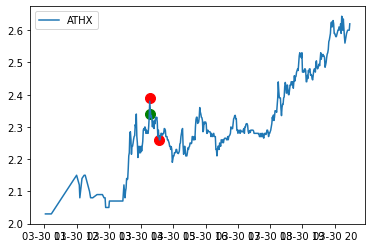

current_value=3.19 series = [3.145  3.135  3.14   3.14   3.14   3.18   3.165  3.1685 3.17   3.17
 3.17   3.19   3.185  3.185  3.165  3.1671 3.17   3.165  3.165  3.1359
 3.135  3.135  3.1299 3.125  3.125  3.12   3.12   3.125  3.125  3.125
 3.115  3.105  3.085  3.085  3.0585 3.055  3.055  3.055  3.0599 3.055
 3.055  3.055 ]
[]
{}
resistances=[]
current_value=3.19 series = [3.145  3.135  3.14   3.14   3.14   3.18   3.165  3.1685 3.17   3.17
 3.17   3.19   3.185  3.185  3.165  3.1671 3.17   3.165  3.165  3.1359
 3.135  3.135  3.1299 3.125  3.125  3.12   3.12   3.125  3.125  3.125
 3.115  3.105  3.085  3.085  3.0585 3.055  3.055  3.055  3.0599 3.055
 3.055  3.055 ]
[3.055, 3.055, 3.0599, 3.085, 3.125, 3.125, 3.125, 3.125, 3.135, 3.14, 3.14, 3.165, 3.17, 3.17, 3.17, 3.18, 3.185, 3.19]
{1: [3.055, 3.055, 3.0599, 3.085], 2: [3.125, 3.125, 3.125, 3.125, 3.135, 3.14, 3.14, 3.165, 3.17, 3.17, 3.17, 3.18, 3.185, 3.19]}
supports=[3.06, 3.15]
AMRX analysis for run 122 with profit -32.24


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2571.14,-2571.14,buy,2020-03-30 14:21:43.181528,3.19,"[3.06, 3.15]",[],806,"{'rsi': 59.19058780770992, 'macd': [0.014595127083716797, 0.015056061600075221, 0.015117978254201248, 0.01619078499741411, 0.017245653129590366], 'sell_macd': [0.007836531728843799, 0.008179555940461825, 0.008257502651586979, 0.008990220833612117, 0.009704154211376714], 'slow macd': [0.019830901627976072, 0.019995926064706016, 0.02009018337164603, 0.020384675706624833, 0.020702983647432394], 'macd_signal': [0.01314131104978784, 0.013524261159845317, 0.013843004578716503, 0.014312560662456024, 0.014899179155882892], 'sell_macd_signal': [0.0066929956294013385, 0.006990307691613436, 0.007243746683608145, 0.007593041513608939, 0.008015264053162495]}",3.49,3.09
1,-32.24,2538.90,sell,2020-03-30 14:41:12.994112,3.15,None,None,806,"{'rsi': 43.22353506202527, 'reasons': 'below cost & macd negative', 'movement': -0.012539184952978068, 'sell_macd': [0.002071169569181297, 0.0018378364419104898, 0.0008529296357004945, 0.0005938732979302586, -0.00039492220290249236], 'sell_macd_signal': [0.004142197290824197, 0.003681325121041456, 0.0031156460239732636, 0.0026112914787646624, 0.0020100487424312315]}",3.49,3.09


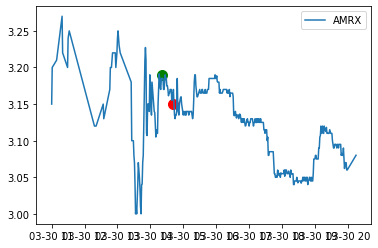

current_value=8.21 series = [8.17  8.17  8.15  8.155 8.14  8.17  8.185 8.18  8.17  8.185 8.23  8.24
 8.24  8.215 8.245 8.22  8.225 8.25  8.245 8.26  8.27  8.25  8.235 8.24
 8.27  8.255 8.23  8.21  8.2   8.17  8.175 8.19  8.19  8.17  8.17  8.13
 8.145 8.155 8.155 8.18 ]
[8.24, 8.24, 8.245, 8.25, 8.27, 8.27]
{1: [8.24, 8.24, 8.245, 8.25, 8.27, 8.27]}
resistances=[8.25]
current_value=8.21 series = [8.17  8.17  8.15  8.155 8.14  8.17  8.185 8.18  8.17  8.185 8.23  8.24
 8.24  8.215 8.245 8.22  8.225 8.25  8.245 8.26  8.27  8.25  8.235 8.24
 8.27  8.255 8.23  8.21  8.2   8.17  8.175 8.19  8.19  8.17  8.17  8.13
 8.145 8.155 8.155 8.18 ]
[8.155, 8.155, 8.17, 8.17, 8.185, 8.19, 8.19]
{1: [8.155, 8.155, 8.17, 8.17, 8.185, 8.19, 8.19]}
supports=[8.17]
AMCR analysis for run 122 with profit -73.3


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6017.93,-6017.93,buy,2020-03-30 14:35:12.962556,8.21,[8.17],[8.25],733,"{'rsi': 64.03378378153889, 'macd': [0.009264746737088103, 0.010572293688287715, 0.011236926841641903, 0.01386321290946313, 0.01695944030836216], 'sell_macd': [0.004152949572722164, 0.00508372815649949, 0.005587143570396691, 0.007361400469923396, 0.00942755648942395], 'slow macd': [0.029098492063839743, 0.02899192895600855, 0.028799538141557335, 0.029024292473177837, 0.02942455738607741], 'macd_signal': [0.012726831294424024, 0.012295923773196762, 0.01208412438688579, 0.012439942091401259, 0.01334384173479344], 'sell_macd_signal': [0.006121644859303883, 0.005914061518743004, 0.005848677929073742, 0.006151222437243672, 0.006806489247679728]}",8.54,8.1
1,-73.30,5944.63,sell,2020-03-30 14:45:10.238160,8.11,None,None,733,"{'rsi': 41.368547204583685, 'reasons': 'below cost & macd negative', 'movement': -0.01218026796589542, 'sell_macd': [0.008547144992350653, 0.006343365361420439, 0.002985311553404202, 0.0003298759685428365, -0.002263059240032561], 'sell_macd_signal': [0.008865450710628912, 0.008361033640787217, 0.007285889223310614, 0.005894686572357059, 0.004263137409879135]}",8.54,8.1


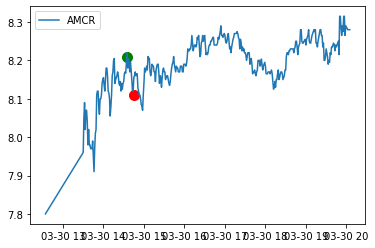

current_value=7.58 series = [7.54   7.58   7.6    7.68   7.66   7.67   7.65   7.66   7.65   7.63
 7.56   7.61   7.61   7.58   7.61   7.59   7.51   7.48   7.47   7.48
 7.45   7.45   7.44   7.46   7.46   7.46   7.5    7.48   7.52   7.51
 7.54   7.53   7.5    7.5    7.49   7.52   7.565  7.5727 7.59   7.595
 7.57   7.54   7.55   7.52   7.52   7.51   7.51   7.51   7.51  ]
[7.595, 7.61, 7.61, 7.61, 7.66, 7.67, 7.68]
{1: [7.595, 7.61, 7.61, 7.61, 7.66, 7.67, 7.68]}
resistances=[7.63]
current_value=7.58 series = [7.54   7.58   7.6    7.68   7.66   7.67   7.65   7.66   7.65   7.63
 7.56   7.61   7.61   7.58   7.61   7.59   7.51   7.48   7.47   7.48
 7.45   7.45   7.44   7.46   7.46   7.46   7.5    7.48   7.52   7.51
 7.54   7.53   7.5    7.5    7.49   7.52   7.565  7.5727 7.59   7.595
 7.57   7.54   7.55   7.52   7.52   7.51   7.51   7.51   7.51  ]
[7.45, 7.46, 7.46, 7.48, 7.5, 7.5, 7.51, 7.51, 7.52, 7.52, 7.54, 7.55]
{1: [7.45, 7.46, 7.46, 7.48, 7.5, 7.5, 7.51, 7.51, 7.52, 7.52, 7.54, 7.55]}
s

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2183.04,-2183.04,buy,2020-03-30 14:25:23.208502,7.58,[7.5],[7.63],288,"{'rsi': 67.00758306422253, 'macd': [0.02663803031191314, 0.0285911599475428, 0.0313910061299012, 0.032612640533402626, 0.03780095648448345], 'sell_macd': [0.014233948475030012, 0.015571211499036508, 0.017449972147626447, 0.01828731846928555, 0.021699701077470657], 'slow macd': [0.036761301884499, 0.03726814632330111, 0.03799472627867484, 0.03847928508403253, 0.03978638331305806], 'macd_signal': [0.028951257010993346, 0.028879237598303235, 0.02938159130462283, 0.03002780115037879, 0.031582432217199724], 'sell_macd_signal': [0.015606795246055455, 0.015599678496651666, 0.015969737226846623, 0.01643325347533441, 0.017486542995761658]}",8.43,7.31
1,-11.52,2171.52,sell,2020-03-30 15:10:31.177515,7.54,None,None,288,"{'rsi': 39.68002078701418, 'reasons': 'below cost & macd negative', 'movement': -0.0026350461133069266, 'sell_macd': [0.005250324126519601, 0.004629080465193169, 0.0030459155282480666, -0.00030519890999869403, -0.004470934850060004], 'sell_macd_signal': [0.008055241327984256, 0.007370009155426039, 0.006505190429990444, 0.0051431125619926165, 0.003220303079582092]}",8.43,7.31


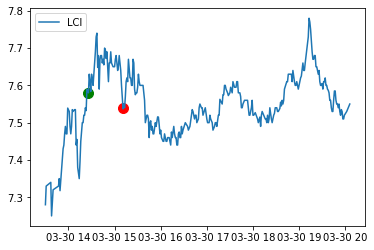

current_value=2.07 series = [2.01   2.01   2.015  2.005  1.98   1.97   1.975  1.97   1.97   1.98
 1.995  1.995  1.985  1.96   1.9625 1.965  1.955  1.955  1.969  1.955
 1.955  1.955  1.955  1.945  1.945  1.94   1.94   1.935  1.935  1.935
 1.94   1.925  1.915  1.91   1.895  1.895  1.8401 1.815  1.815  1.825
 1.825 ]
[]
{}
resistances=[]
current_value=2.07 series = [2.01   2.01   2.015  2.005  1.98   1.97   1.975  1.97   1.97   1.98
 1.995  1.995  1.985  1.96   1.9625 1.965  1.955  1.955  1.969  1.955
 1.955  1.955  1.955  1.945  1.945  1.94   1.94   1.935  1.935  1.935
 1.94   1.925  1.915  1.91   1.895  1.895  1.8401 1.815  1.815  1.825
 1.825 ]
[1.825, 1.895, 1.935, 1.94, 1.94, 1.945, 1.955, 1.955, 1.955, 1.965, 1.969, 1.975, 1.995, 1.995, 2.015]
{1: [1.825], 2: [1.895], 3: [1.935, 1.94, 1.94, 1.945, 1.955, 1.955, 1.955, 1.965, 1.969, 1.975], 4: [1.995, 1.995], 5: [2.015]}
supports=[1.95, 2.0]
HL analysis for run 122 with profit -42.45


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1757.43,-1757.43,buy,2020-03-30 14:24:34.083118,2.07,"[1.95, 2.0]",[],849,"{'rsi': 73.0467445563913, 'macd': [0.008244231042559225, 0.009165699454203757, 0.010580916022253195, 0.012765704888705098, 0.015129676736908682], 'sell_macd': [0.004306712918311195, 0.004936477325614863, 0.005882573262141921, 0.0073226145988889435, 0.008869106360005041], 'slow macd': [0.013644485315754462, 0.01380963476421826, 0.014099426984073515, 0.01458339907121875, 0.015165280789026347], 'macd_signal': [0.008785999352017562, 0.0088619393724548, 0.00920573470241448, 0.009917728739672603, 0.010960118339119819], 'sell_macd_signal': [0.0045471706138563404, 0.004625031956208045, 0.00487654021739482, 0.005365755093693645, 0.006066425346955924]}",2.36,1.98
1,-42.45,1714.98,sell,2020-03-30 14:41:18.123693,2.02,None,None,849,"{'rsi': 45.87454171852679, 'reasons': 'below cost & macd negative', 'movement': -0.021638554216867546, 'sell_macd': [0.0015440199582092973, 0.001100125591229073, 0.0004802062716180444, 0.00025065607099117315, -0.00018601494340630964], 'sell_macd_signal': [0.004260585700875283, 0.003628493678946041, 0.0029988361974804417, 0.002449200172182588, 0.0019221571490648085]}",2.36,1.98


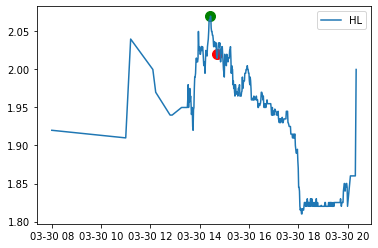

current_value=15.19 series = [14.02   14.01       nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     n

<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2977.24,-2977.24,buy,2020-03-30 14:45:21.131555,15.19,"[14.52, 14.96]",[15.77],196,"{'rsi': 63.73376794264837, 'macd': [0.09790864438233449, 0.10572219463618104, 0.11781859788764137, 0.12555431441926856, 0.13058310299055265], 'sell_macd': [0.056280747596662906, 0.06127261498701486, 0.06904195821343073, 0.07393960282864676, 0.07705543495961109], 'slow macd': [0.05325186761331935, 0.05733867956272576, 0.06244639630696014, 0.06696581679606695, 0.07109669375658356], 'macd_signal': [0.11470726907179188, 0.11291025418466971, 0.11389192292526404, 0.11622440122406494, 0.11909614157736248], 'sell_macd_signal': [0.06839830960874461, 0.06697317068439866, 0.06738692819020507, 0.0686974631178934, 0.07036905748623694]}",16.42,14.78
1,86.24,3063.48,sell,2020-03-30 17:47:27.415614,15.63,None,None,196,"{'rsi': 41.51156665497828, 'reasons': 'below cost & macd negative', 'movement': -0.007893905904641616, 'sell_macd': [0.01792398798447259, 0.013799487978189973, 0.009886897220331647, 0.003592840821735166, -0.0013582789800494766], 'sell_macd_signal': [0.014960105906212726, 0.014727982320608176, 0.013759765300552871, 0.01172638040478933, 0.009109448527821569]}",16.42,14.78


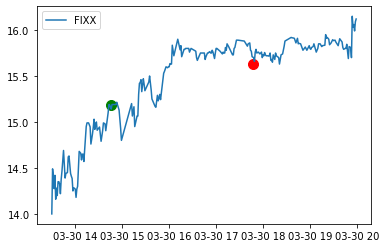

current_value=10.99 series = [11.1    11.09   11.145  11.13   11.21   11.165  11.18   11.17   11.185
 11.205  11.12   11.1148 11.13   11.1699 11.19   11.21   11.22   11.2171
 11.2501 11.21   11.23   11.26   11.245  11.245  11.24   11.25   11.26
 11.27   11.25   11.255  11.2236 11.2    11.24   11.22   11.22   11.25
 11.1999 11.19   11.24   11.275  11.32   11.33   11.345 ]
[11.145, 11.18, 11.205, 11.21, 11.22, 11.24, 11.245, 11.25, 11.2501, 11.255, 11.26, 11.27]
{1: [11.145, 11.18, 11.205, 11.21, 11.22, 11.24, 11.245, 11.25, 11.2501, 11.255, 11.26, 11.27]}
resistances=[11.23]
current_value=10.99 series = [11.1    11.09   11.145  11.13   11.21   11.165  11.18   11.17   11.185
 11.205  11.12   11.1148 11.13   11.1699 11.19   11.21   11.22   11.2171
 11.2501 11.21   11.23   11.26   11.245  11.245  11.24   11.25   11.26
 11.27   11.25   11.255  11.2236 11.2    11.24   11.22   11.22   11.25
 11.1999 11.19   11.24   11.275  11.32   11.33   11.345 ]
[]
{}
supports=[]
YINN analysis for run 122 w

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5165.3,-5165.3,buy,2020-03-30 14:43:06.928682,10.99,[],[11.23],470,"{'rsi': 71.05395242475213, 'macd': [0.03185201959764683, 0.032001468506951625, 0.03255158980618589, 0.0350048006268846, 0.03745327291515821], 'sell_macd': [0.019274036608083023, 0.01931027150575204, 0.01960720426360041, 0.02114238298057991, 0.022666647136919238], 'slow macd': [0.02433088360065483, 0.024895729255941745, 0.025535524112315855, 0.02656312341981959, 0.027651589438567825], 'macd_signal': [0.02431485909250741, 0.025852180975396252, 0.02719206274155418, 0.028754610318620262, 0.030494342837927853], 'sell_macd_signal': [0.01447766858675142, 0.015444189170551546, 0.016276792189161317, 0.017249910347445035, 0.018333257705339875]}",11.51,10.82
1,108.1,5273.4,sell,2020-03-30 15:34:16.224059,11.22,None,None,470,"{'rsi': 71.2965959519345, 'reasons': 'bail', 'movement': 0.020779504348775485, 'sell_macd': [0.02436804489654243, 0.02574721540806202, 0.027006994827322828, 0.026079459377040592, 0.026576451761535225], 'sell_macd_signal': [0.02372197425408328, 0.024127022484879027, 0.02470301695336779, 0.02497830543810235, 0.025297934702788925]}",11.51,10.82


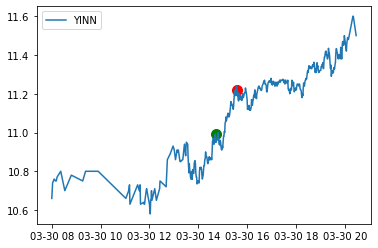

current_value=12.35 series = [12.25  12.25  12.225 12.215 12.18  12.2   12.23  12.18  12.16  12.15
 12.18  12.21  12.255 12.24  12.27  12.23  12.26  12.3   12.28  12.3
 12.3   12.26  12.215 12.22  12.265 12.215 12.19  12.16  12.135 12.1
 12.085 12.14  12.14  12.145 12.11  12.03  12.045 12.04  12.02  12.06
 12.14 ]
[]
{}
resistances=[]
current_value=12.35 series = [12.25  12.25  12.225 12.215 12.18  12.2   12.23  12.18  12.16  12.15
 12.18  12.21  12.255 12.24  12.27  12.23  12.26  12.3   12.28  12.3
 12.3   12.26  12.215 12.22  12.265 12.215 12.19  12.16  12.135 12.1
 12.085 12.14  12.14  12.145 12.11  12.03  12.045 12.04  12.02  12.06
 12.14 ]
[12.045, 12.14, 12.145, 12.23, 12.25, 12.255, 12.265, 12.27, 12.3, 12.3, 12.3]
{1: [12.045, 12.14, 12.145, 12.23, 12.25, 12.255, 12.265, 12.27, 12.3, 12.3, 12.3]}
supports=[12.23]
GPK analysis for run 122 with profit -62.26


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6990.10,-6990.10,buy,2020-03-30 14:35:31.981945,12.35,[12.23],[],566,"{'rsi': 62.149617112068256, 'macd': [-0.005766898345285654, -0.005596764977719104, -0.004601968009081858, -0.0005792414039209604, 0.005769951707289778], 'sell_macd': [-0.005846559017168573, -0.005548224622533127, -0.0047242208783675466, -0.0019428644429364539, 0.002327580369644977], 'slow macd': [0.03261441049572689, 0.031672124207279495, 0.030914471569717605, 0.030807707633167425, 0.03129995287565812], 'macd_signal': [-0.00022970807041622463, -0.0013031194518768007, -0.001962889163317812, -0.0016861596114384418, -0.0001949373476927978], 'sell_macd_signal': [-0.0030463043501781405, -0.0035466884046491376, -0.0037821948993928193, -0.003414328808101546, -0.0022659469725522415]}",12.78,12.21
1,-62.26,6927.84,sell,2020-03-30 14:44:10.926602,12.24,None,None,566,"{'rsi': 43.54199352874052, 'reasons': 'below cost & macd negative', 'movement': -0.00850202429149801, 'sell_macd': [0.005937627914933685, 0.005503698853045691, 0.004055134663873972, 0.0013152777026483875, -0.0010964975619760509], 'sell_macd_signal': [0.0028030494434403744, 0.003343179325361438, 0.0034855703930639446, 0.0030515118549808333, 0.0022219099715894567]}",12.78,12.21


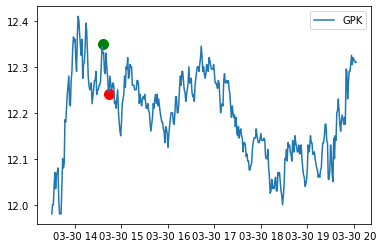

current_value=6.36 series = [6.19   6.16   6.1042 6.14   6.14   6.11   6.1355 6.2456 6.245  6.36
 6.335  6.33   6.26   6.255  6.27   6.29   6.325  6.2935 6.276  6.27
 6.2807 6.295  6.3    6.29   6.3    6.29      nan 6.2959 6.295  6.29
 6.29   6.2501 6.29   6.2723 6.27   6.29   6.28   6.28   6.29   6.295
 6.28   6.2711 6.27   6.24   6.2431 6.245  6.2363 6.23   6.23   6.2101
 6.1825 6.185  6.17   6.156  6.1321 6.16   6.14   6.13  ]
[]
{}
resistances=[]
current_value=6.36 series = [6.19   6.16   6.1042 6.14   6.14   6.11   6.1355 6.2456 6.245  6.36
 6.335  6.33   6.26   6.255  6.27   6.29   6.325  6.2935 6.276  6.27
 6.2807 6.295  6.3    6.29   6.3    6.29      nan 6.2959 6.295  6.29
 6.29   6.2501 6.29   6.2723 6.27   6.29   6.28   6.28   6.29   6.295
 6.28   6.2711 6.27   6.24   6.2431 6.245  6.2363 6.23   6.23   6.2101
 6.1825 6.185  6.17   6.156  6.1321 6.16   6.14   6.13  ]
[6.14, 6.14, 6.16, 6.185, 6.23, 6.245, 6.2456, 6.29, 6.29, 6.29, 6.295, 6.3, 6.3, 6.325, 6.36]
{1: [6.14, 6.14,

<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1933.44,-1933.44,buy,2020-03-30 14:18:33.603962,6.36,[6.25],[],304,"{'rsi': 73.31125371004579, 'macd': [0.05280019565185157, 0.05915142488732972, 0.0624243090474641, 0.06685378456839608, 0.06937882909826065], 'sell_macd': [0.029717222770632823, 0.03389838834095027, 0.03604607075495103, 0.03892938080800512, 0.04055105902066991], 'slow macd': [0.06611086404779165, 0.06771330643539653, 0.0688729892455271, 0.0703463751668103, 0.07155264286141438], 'macd_signal': [0.05072402133137092, 0.05240950204256268, 0.05441246344354296, 0.05690072766851358, 0.059396347954463], 'sell_macd_signal': [0.028053561472078485, 0.02922252684585284, 0.03058723562767248, 0.03225566466373901, 0.03391474353512519]}",7.15,6.1
1,-27.36,1906.08,sell,2020-03-30 15:06:21.350509,6.27,None,None,304,"{'rsi': 45.69513315022039, 'reasons': 'below cost & macd negative', 'movement': -0.014150943396226532, 'sell_macd': [0.004095328265943721, 0.0032867750368490434, 0.002354307909802955, 0.0017010308249645334, -0.0002327049661428049], 'sell_macd_signal': [0.009096287692179808, 0.007934385161113656, 0.006818369710851516, 0.00579490193367412, 0.004589380553710735]}",7.15,6.1


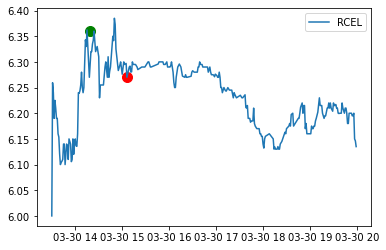

current_value=15.31 series = [15.34  15.39  15.32  15.21  15.15  15.135 15.165 15.24  15.3   15.26
 15.33  15.3   15.37  15.33  15.37  15.38  15.39  15.36  15.42  15.62
 15.61  15.61  15.495 15.49  15.51  15.51  15.54  15.53  15.46  15.46
 15.48  15.51  15.55  15.605 15.61  15.625 15.615 15.625 15.64  15.64
 15.635 15.63 ]
[15.33, 15.37, 15.39, 15.39, 15.51, 15.54, 15.61, 15.62, 15.625, 15.64, 15.64]
{1: [15.33, 15.37, 15.39, 15.39, 15.51, 15.54, 15.61, 15.62, 15.625, 15.64, 15.64]}
resistances=[15.51]
current_value=15.31 series = [15.34  15.39  15.32  15.21  15.15  15.135 15.165 15.24  15.3   15.26
 15.33  15.3   15.37  15.33  15.37  15.38  15.39  15.36  15.42  15.62
 15.61  15.61  15.495 15.49  15.51  15.51  15.54  15.53  15.46  15.46
 15.48  15.51  15.55  15.605 15.61  15.625 15.615 15.625 15.64  15.64
 15.635 15.63 ]
[15.3]
{1: [15.3]}
supports=[]
JHG analysis for run 122 with profit -6.93


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1178.87,-1178.87,buy,2020-03-30 14:09:00.410720,15.31,[],[15.51],77,"{'rsi': 66.79668615311569, 'macd': [0.12196370509509613, 0.12295200552086172, 0.12711147730149364, 0.12892175886977952, 0.1312640391996922], 'sell_macd': [0.07666650298685873, 0.07678304469759567, 0.07899355713846035, 0.07969014401265895, 0.08075644360277856], 'slow macd': [0.027719546367627856, 0.03163701372691641, 0.036150226177461775, 0.04024470876202635, 0.04442720599994665], 'macd_signal': [0.11097851530440023, 0.11337321334769253, 0.11612086613845275, 0.1186810446847181, 0.12119764358771293], 'sell_macd_signal': [0.07190282655294761, 0.07287887018187722, 0.07410180757319385, 0.07521947486108686, 0.0763268686094252]}",18.45,14.27
1,-6.93,1171.94,sell,2020-03-30 14:55:12.132556,15.22,None,None,77,"{'rsi': 42.61047054869429, 'reasons': 'below cost & macd negative', 'movement': -0.004898758981058201, 'sell_macd': [0.02092860746114411, 0.01704203749343236, 0.011194813655041713, 0.004415226071165179, -0.0011846503068060343], 'sell_macd_signal': [0.021286846944436964, 0.020437885054236042, 0.018589270774397176, 0.015754461833750778, 0.012366639405639415]}",18.45,14.27


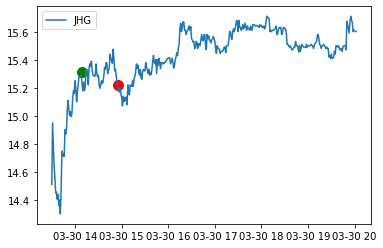

current_value=5.5 series = [5.525  5.47   5.48   5.485  5.48   5.495  5.48   5.46   5.43   5.45
 5.44   5.42   5.39   5.43   5.4    5.35   5.3    5.33   5.33   5.325
 5.33   5.3    5.28   5.28   5.29   5.29   5.31   5.29   5.2899 5.28
 5.28   5.29   5.295  5.275  5.26   5.29   5.32   5.325  5.345  5.34
 5.33   5.34   5.32   5.32   5.31   5.31   5.285  5.26  ]
[]
{}
resistances=[]
current_value=5.5 series = [5.525  5.47   5.48   5.485  5.48   5.495  5.48   5.46   5.43   5.45
 5.44   5.42   5.39   5.43   5.4    5.35   5.3    5.33   5.33   5.325
 5.33   5.3    5.28   5.28   5.29   5.29   5.31   5.29   5.2899 5.28
 5.28   5.29   5.295  5.275  5.26   5.29   5.32   5.325  5.345  5.34
 5.33   5.34   5.32   5.32   5.31   5.31   5.285  5.26  ]
[5.29, 5.295, 5.31, 5.31, 5.32, 5.33, 5.33, 5.33, 5.34, 5.345, 5.43, 5.45, 5.485, 5.495]
{1: [5.29, 5.295, 5.31, 5.31, 5.32, 5.33, 5.33, 5.33, 5.34, 5.345], 2: [5.43, 5.45, 5.485, 5.495]}
supports=[5.32, 5.46]
CRBP analysis for run 122 with profit -31.36


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2464.00,-2464.00,buy,2020-03-30 14:14:26.476725,5.50,"[5.32, 5.46]",[],448,"{'rsi': 63.760832093401696, 'macd': [0.015695669731871753, 0.016883063323649417, 0.018817539062807143, 0.022910731860577016, 0.02824972072651466], 'sell_macd': [0.009372101155767254, 0.010109031650842759, 0.011331197859332676, 0.013954558569073683, 0.017375949270571844], 'slow macd': [0.003065018520056917, 0.003833597172521408, 0.004774486852901383, 0.006192275420331406, 0.007966590651029115], 'macd_signal': [0.01590300982710357, 0.01609902052641274, 0.01664272423369162, 0.017896325759068698, 0.01996700475255789], 'sell_macd_signal': [0.009757960882818825, 0.009828175036423612, 0.010128779601005425, 0.010893935394619077, 0.01219033816980963]}",6.04,5.32
1,-31.36,2432.64,sell,2020-03-30 14:52:24.465265,5.43,None,None,448,"{'rsi': 40.852962436861986, 'reasons': 'below cost & macd negative', 'movement': -0.00909090909090906, 'sell_macd': [0.002642267043674096, 0.002731871597858593, 0.002246733956991598, 0.0008005652244067463, -0.0013756774922102366], 'sell_macd_signal': [0.004630278211064979, 0.0042505968884237015, 0.003849824302137281, 0.003239972486591174, 0.0023168424908308915]}",6.04,5.32


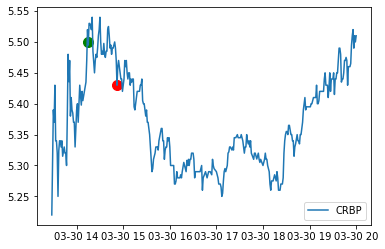

current_value=8.1 series = [7.55   7.57   7.69   7.685  7.6601 7.6308 7.93   8.06   8.17   8.19
 7.91   7.86   7.86   7.9001 7.925  8.01   8.105  8.185  8.2525 8.26
 8.285  8.43   8.49   8.405  8.49   8.525  8.525  8.5136 8.3    8.31
 8.25   8.24   8.24   8.16   8.08   8.04   8.02   7.98   7.97   7.98
 8.09   8.15   8.12   8.05   8.0465 7.95   7.9976 7.99   7.9576 7.9201
 7.9    7.885  7.78   7.76   7.79   7.8   ]
[8.15, 8.19, 8.24, 8.31, 8.49, 8.525, 8.525]
{1: [8.15, 8.19, 8.24, 8.31], 2: [8.49, 8.525, 8.525]}
resistances=[8.22, 8.51]
current_value=8.1 series = [7.55   7.57   7.69   7.685  7.6601 7.6308 7.93   8.06   8.17   8.19
 7.91   7.86   7.86   7.9001 7.925  8.01   8.105  8.185  8.2525 8.26
 8.285  8.43   8.49   8.405  8.49   8.525  8.525  8.5136 8.3    8.31
 8.25   8.24   8.24   8.16   8.08   8.04   8.02   7.98   7.97   7.98
 8.09   8.15   8.12   8.05   8.0465 7.95   7.9976 7.99   7.9576 7.9201
 7.9    7.885  7.78   7.76   7.79   7.8   ]
[7.69, 7.9976]
{1: [7.69], 2: [7.9976]}

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1328.40,-1328.40,buy,2020-03-30 14:37:46.253766,8.10,[],"[8.22, 8.51]",164,"{'rsi': 72.42514477818006, 'macd': [0.14167916710125983, 0.14347119517208284, 0.14882425197774563, 0.15610856426733744, 0.1608343523658231], 'sell_macd': [0.08072852728214563, 0.08190852507655055, 0.08540062043483232, 0.09012951785122336, 0.09316334028151285], 'slow macd': [0.13242411958083888, 0.13485907380052797, 0.13800317350636693, 0.1416347451693456, 0.14490931830642495], 'macd_signal': [0.1396227549855952, 0.14039244302289272, 0.1420788048138633, 0.14488475670455814, 0.14807467583681114], 'sell_macd_signal': [0.07953084510833316, 0.08000638110197664, 0.08108522896854778, 0.08289408674508289, 0.08494793745236888]}",9.57,7.61
1,-42.64,1285.76,sell,2020-03-30 14:58:58.393774,7.84,None,None,164,"{'rsi': 43.71929459946282, 'reasons': 'below cost & macd negative', 'movement': -0.05180109537481605, 'sell_macd': [0.03746142075539893, 0.027110274746853236, 0.015315741821403606, 0.0064457714662298216, -0.000549605063337566], 'sell_macd_signal': [0.07019090515858017, 0.061574779076234785, 0.05232297162526855, 0.043147531593460804, 0.03440810426210113]}",9.57,7.61


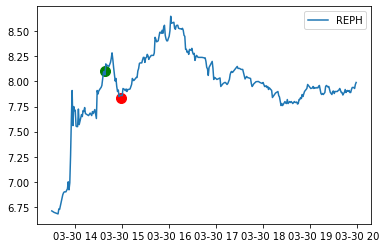

current_value=2.21 series = [2.12  nan  nan ...  nan 2.25 2.28]
[2.2207, 2.3, 2.3033, 2.31, 2.32, 2.325, 2.33, 2.33, 2.34, 2.34]
{1: [2.2207], 2: [2.3, 2.3033, 2.31, 2.32, 2.325, 2.33, 2.33, 2.34, 2.34]}
resistances=[2.32]
current_value=2.21 series = [2.12  nan  nan ...  nan 2.25 2.28]
[2.06, 2.09, 2.09, 2.1, 2.1, 2.12, 2.18, 2.18, 2.18, 2.18, 2.19]
{1: [2.06], 2: [2.09, 2.09, 2.1, 2.1, 2.12], 3: [2.18, 2.18, 2.18, 2.18, 2.19]}
supports=[2.1, 2.18]
OCX analysis for run 122 with profit 80.64


<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4455.36,-4455.36,buy,2020-03-30 14:38:54.549921,2.21,"[2.1, 2.18]",[2.32],2016,"{'rsi': 60.930768305955795, 'macd': [0.021402174354694825, 0.02430145532017658, 0.025921103309426652, 0.027269589872976674, 0.028015331882903727], 'sell_macd': [0.014272195771138918, 0.016043950632097292, 0.01697201999606346, 0.017718930929075505, 0.018070823462213337], 'slow macd': [0.0060676102370860185, 0.007207624573628557, 0.008169776708810694, 0.00911709096559532, 0.009974068870832742], 'macd_signal': [0.008376691197641943, 0.01156164402214887, 0.014433535879604427, 0.017000746678278875, 0.019203663719203845], 'sell_macd_signal': [0.0059442659463409256, 0.0079642028834922, 0.009765766306006451, 0.011356399230620262, 0.012699284076938877]}",2.33,2.17
1,80.64,4536.00,sell,2020-03-30 15:04:01.540225,2.25,None,None,2016,"{'rsi': 68.21842923158354, 'reasons': 'bail', 'movement': 0.036199095022624465, 'sell_macd': [0.017228743296585858, 0.0157159219532943, 0.015371958283803444, 0.015423779342852217, 0.018380733683112993], 'sell_macd_signal': [0.016622932402300176, 0.016441530312499, 0.01622761590675989, 0.016066848593978354, 0.016529625611805283]}",2.33,2.17


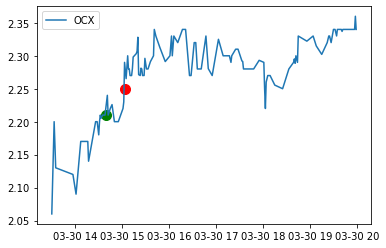

current_value=11.92 series = [11.89   11.78   11.64   11.65   11.83   11.87   11.87   11.85   11.93
 11.91   11.9    11.87   11.8    11.76   11.6525 11.51   11.52   11.5
 11.54   11.64   11.62   11.62   11.69   11.685  11.635  11.64   11.68
 11.69   11.66   11.62   11.47   11.52   11.52   11.56   11.515  11.43
 11.44   11.46   11.37   11.45   11.41   11.49   11.58   11.61  ]
[11.93]
{1: [11.93]}
resistances=[]
current_value=11.92 series = [11.89   11.78   11.64   11.65   11.83   11.87   11.87   11.85   11.93
 11.91   11.9    11.87   11.8    11.76   11.6525 11.51   11.52   11.5
 11.54   11.64   11.62   11.62   11.69   11.685  11.635  11.64   11.68
 11.69   11.66   11.62   11.47   11.52   11.52   11.56   11.515  11.43
 11.44   11.46   11.37   11.45   11.41   11.49   11.58   11.61  ]
[11.45, 11.46, 11.52, 11.52, 11.56, 11.64, 11.69, 11.69, 11.87, 11.87]
{1: [11.45, 11.46, 11.52, 11.52, 11.56, 11.64, 11.69, 11.69], 2: [11.87, 11.87]}
supports=[11.57, 11.87]
INVA analysis for run 122 with p

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3432.96,-3432.96,buy,2020-03-30 14:37:37.413972,11.92,"[11.57, 11.87]",[],288,"{'rsi': 60.56140190294034, 'macd': [0.0346031819286825, 0.03943896290896731, 0.04357595412817439, 0.047916036090480674, 0.051568054310630274], 'sell_macd': [0.018154012685089427, 0.021416637438980146, 0.02420028481293457, 0.02709403231454921, 0.029516510467566093], 'slow macd': [0.06331913561259483, 0.06403203814765313, 0.06474545701233936, 0.06561814592861026, 0.06647603661738444], 'macd_signal': [0.039387107122320617, 0.039397478279649956, 0.04023317344935484, 0.04176974597758001, 0.04372940764419006], 'sell_macd_signal': [0.02084318518731055, 0.02095787563764447, 0.021606357472702488, 0.02270389244107183, 0.024066416046370685]}",12.76,11.64
1,-37.44,3395.52,sell,2020-03-30 14:59:31.212629,11.79,None,None,288,"{'rsi': 41.92104522828685, 'reasons': 'below cost & macd negative', 'movement': -0.009647651006711427, 'sell_macd': [0.008217049772555995, 0.00807327406590197, 0.004739510215705067, 0.0007815187711912586, -0.0033517410397454483], 'sell_macd_signal': [0.016614196771874222, 0.014906012230679772, 0.01287271182768483, 0.010454473216386116, 0.007693230365159803]}",12.76,11.64


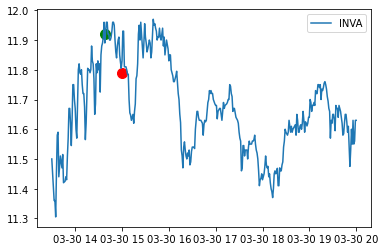

current_value=11.53 series = [11.46  11.54  11.61  11.59  11.58  11.6   11.56  11.53  11.5   11.55
 11.55  11.57  11.58  11.55  11.52  11.48  11.42  11.33  11.32  11.33
 11.37  11.36  11.38  11.44  11.44  11.43  11.4   11.385 11.41  11.42
 11.43  11.43  11.41  11.38  11.4   11.44  11.43  11.4   11.42  11.41
 11.37  11.36  11.4  ]
[11.55, 11.58, 11.6, 11.61]
{1: [11.55, 11.58, 11.6, 11.61]}
resistances=[11.58]
current_value=11.53 series = [11.46  11.54  11.61  11.59  11.58  11.6   11.56  11.53  11.5   11.55
 11.55  11.57  11.58  11.55  11.52  11.48  11.42  11.33  11.32  11.33
 11.37  11.36  11.38  11.44  11.44  11.43  11.4   11.385 11.41  11.42
 11.43  11.43  11.41  11.38  11.4   11.44  11.43  11.4   11.42  11.41
 11.37  11.36  11.4  ]
[11.37, 11.42, 11.43, 11.43, 11.44, 11.44, 11.44]
{1: [11.37, 11.42, 11.43, 11.43, 11.44, 11.44, 11.44]}
supports=[11.42]
CORT analysis for run 122 with profit -21.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3574.3,-3574.3,buy,2020-03-30 14:28:09.888898,11.53,[11.42],[11.58],310,"{'rsi': 59.68125748769402, 'macd': [0.02157740859541768, 0.0173977214832437, 0.017115656406945234, 0.021485939821161537, 0.027855980218953746], 'sell_macd': [0.010111038034578357, 0.007542509397106656, 0.007521025921191082, 0.010523493005916151, 0.014804331084846467], 'slow macd': [0.05398553758812241, 0.05265568451519265, 0.051987705843114185, 0.052249613181048815, 0.05304675445728435], 'macd_signal': [0.028814031441870037, 0.02653076945014477, 0.024647746841504864, 0.0240153854374362, 0.02478350439373971], 'sell_macd_signal': [0.014267968568615712, 0.012922876734313901, 0.011842506571689337, 0.011578703858534701, 0.012223829303797054]}",12.32,11.28
1,-21.7,3552.6,sell,2020-03-30 14:54:08.715295,11.46,None,None,310,"{'rsi': 47.06002227614438, 'reasons': 'below cost & macd negative', 'movement': -0.00433275563258223, 'sell_macd': [0.01025112444129661, 0.007893882921701234, 0.003357150790566976, 0.0008173965222724178, -0.00117224831694962], 'sell_macd_signal': [0.016224759536204954, 0.01455858421330421, 0.012318297528756763, 0.010018117327459894, 0.007780044198577991]}",12.32,11.28


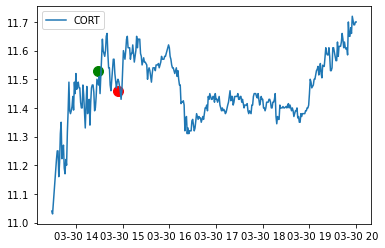

current_value=4.98 series = [4.86      nan 5.19   5.11      nan 4.95   4.79   4.84   4.7336 4.72
 4.73   4.73   4.724  4.77   4.78   4.81   4.95   4.93   4.94   4.9804
 4.8    4.88   4.9    4.9    4.965  5.     5.0608 5.1256 5.1154 5.18
 5.16   5.145  5.13   5.14   5.02   5.065  4.85   4.9906 4.9    4.62
 4.69   4.75   4.66   4.7    4.735  4.78   4.86      nan 4.7998 4.75
 4.73   4.74   4.7    4.72   4.72   4.8    4.8    4.88   4.98   4.92
 4.97   5.     5.12   5.18   5.21  ]
[4.9804, 4.9906, 5.065, 5.1256, 5.14, 5.18]
{1: [4.9804, 4.9906], 2: [5.065], 3: [5.1256, 5.14, 5.18]}
resistances=[4.99, 5.15]
current_value=4.98 series = [4.86      nan 5.19   5.11      nan 4.95   4.79   4.84   4.7336 4.72
 4.73   4.73   4.724  4.77   4.78   4.81   4.95   4.93   4.94   4.9804
 4.8    4.88   4.9    4.9    4.965  5.     5.0608 5.1256 5.1154 5.18
 5.16   5.145  5.13   5.14   5.02   5.065  4.85   4.9906 4.9    4.62
 4.69   4.75   4.66   4.7    4.735  4.78   4.86      nan 4.7998 4.75
 4.73   4.74   4

<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1743.0,-1743.0,buy,2020-03-30 14:25:12.817417,4.98,"[4.73, 4.82, 4.96]","[4.99, 5.15]",350,"{'rsi': 71.77175769463942, 'macd': [0.04457834711942166, 0.04701928276637801, 0.04999130604799529, 0.05175011282364306, 0.05732467525101814], 'sell_macd': [0.02657546471157257, 0.028120640972201016, 0.029998432331492353, 0.031072056347414723, 0.034621996407257605], 'slow macd': [0.03888942947808083, 0.0400273608964925, 0.04133014808169033, 0.04246265216838019, 0.04439629522907573], 'macd_signal': [0.0318686599961226, 0.034898784550173687, 0.03791728884973801, 0.04068385364451902, 0.04401201796581884], 'sell_macd_signal': [0.018160968247982516, 0.020152902792826215, 0.022122008700559442, 0.0239120182299305, 0.02605401386539592]}",5.67,4.75
1,-70.0,1673.0,sell,2020-03-30 14:43:34.872441,4.78,None,None,350,"{'rsi': 35.614008154564985, 'reasons': 'below cost & macd negative', 'movement': -0.04016064257028116, 'sell_macd': [0.027250074197615604, 0.02225627844703304, 0.014439602817397201, 0.0050442763161564486, -0.002342267403202314], 'sell_macd_signal': [0.029497646085125652, 0.02804937255750713, 0.025327418609485144, 0.021270790150819403, 0.01654817864001506]}",5.67,4.75


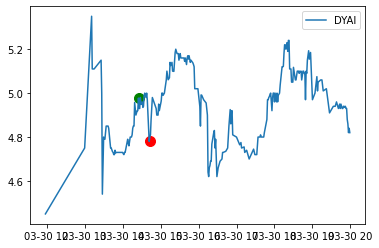

current_value=8.24 series = [8.1    8.11   8.11   8.1    8.125  8.13   8.11   8.05   7.99   8.
 8.04   8.0174 8.0468 8.075  8.09   8.0799 8.09   8.09   8.09   8.09
 8.105  8.1    8.09   8.1052 8.13   8.16   8.15   8.18   8.2    8.23
 8.22   8.24   8.27   8.2357 8.175  8.2    8.17   8.16   8.16   8.16
 8.17  ]
[8.27]
{1: [8.27]}
resistances=[]
current_value=8.24 series = [8.1    8.11   8.11   8.1    8.125  8.13   8.11   8.05   7.99   8.
 8.04   8.0174 8.0468 8.075  8.09   8.0799 8.09   8.09   8.09   8.09
 8.105  8.1    8.09   8.1052 8.13   8.16   8.15   8.18   8.2    8.23
 8.22   8.24   8.27   8.2357 8.175  8.2    8.17   8.16   8.16   8.16
 8.17  ]
[8.04, 8.09, 8.09, 8.09, 8.09, 8.105, 8.11, 8.11, 8.13, 8.16, 8.16, 8.2, 8.23]
{1: [8.04, 8.09, 8.09, 8.09, 8.09, 8.105, 8.11, 8.11, 8.13, 8.16, 8.16, 8.2, 8.23]}
supports=[8.12]
TEVA analysis for run 122 with profit -37.44


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2373.12,-2373.12,buy,2020-03-30 14:17:10.107539,8.24,[8.12],[],288,"{'rsi': 70.57892232204411, 'macd': [0.04817612489168077, 0.05010817159924663, 0.05237506663680769, 0.0602232030151022, 0.06585324487256905], 'sell_macd': [0.025412605793839305, 0.026788512196933567, 0.028375081963021742, 0.033585719677335035, 0.037318869588784054], 'slow macd': [0.06842735725469495, 0.06900259235538808, 0.06968696084690063, 0.07154221236852543, 0.07316826790702358], 'macd_signal': [0.0615729816711025, 0.059280019656731325, 0.057899029052746596, 0.05836386384521772, 0.059861740050687985], 'sell_macd_signal': [0.03405194208309202, 0.03259925610586033, 0.03175442127729261, 0.0321206809573011, 0.033160318683597687]}",9.11,7.99
1,-37.44,2335.68,sell,2020-03-30 14:33:07.966063,8.11,None,None,288,"{'rsi': 39.34753581907704, 'reasons': 'below cost & macd negative', 'movement': -0.022370012091898275, 'sell_macd': [0.015987686259403944, 0.01112985063239158, 0.007007772862870354, 0.001367091836453227, -0.003045998467721134], 'sell_macd_signal': [0.026696794714490636, 0.023583405898070824, 0.02026827929103073, 0.01648804180011523, 0.012581233746547956]}",9.11,7.99


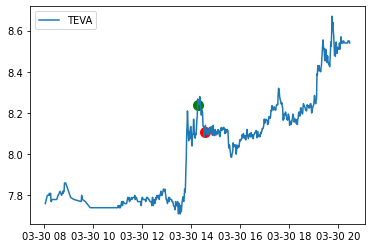

current_value=6.88 series = [6.57   6.585  6.56   6.585  6.56   6.62   6.69   6.62   6.63   6.64
 6.65   6.67   6.655  6.58   6.5799 6.585  6.56   6.57   6.555  6.5
 6.5    6.49   6.495  6.49   6.43   6.36   6.375  6.315  6.325  6.355
 6.325  6.33   6.27   6.27   6.27   6.285  6.315  6.29   6.31   6.34  ]
[]
{}
resistances=[]
current_value=6.88 series = [6.57   6.585  6.56   6.585  6.56   6.62   6.69   6.62   6.63   6.64
 6.65   6.67   6.655  6.58   6.5799 6.585  6.56   6.57   6.555  6.5
 6.5    6.49   6.495  6.49   6.43   6.36   6.375  6.315  6.325  6.355
 6.325  6.33   6.27   6.27   6.27   6.285  6.315  6.29   6.31   6.34  ]
[6.27, 6.315, 6.33, 6.355, 6.375, 6.495, 6.5, 6.57, 6.585, 6.585, 6.585, 6.67, 6.69]
{1: [6.27, 6.315, 6.33, 6.355, 6.375], 2: [6.495, 6.5], 3: [6.57, 6.585, 6.585, 6.585], 4: [6.67, 6.69]}
supports=[6.33, 6.5, 6.58, 6.68]
GLUU analysis for run 122 with profit -34.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2641.92,-2641.92,buy,2020-03-30 14:45:28.211287,6.88,"[6.33, 6.5, 6.58, 6.68]",[],384,"{'rsi': 62.90488136637722, 'macd': [-0.01301973445391269, -0.009697935749841236, -0.0053894275258556945, 0.00044076470120835154, 0.006598997760005609], 'sell_macd': [-0.010017114480086242, -0.0076718584076713725, -0.004705790579716762, -0.0007750131737811472, 0.0033369564045289124], 'slow macd': [0.04466037308915993, 0.043692407368149944, 0.043051840093652594, 0.04287345038593848, 0.04296062810725321], 'macd_signal': [-0.005076701219868745, -0.006000948125863243, -0.0058786440058617336, -0.004614762264447717, -0.0023720102595570516], 'sell_macd_signal': [-0.005572528120262303, -0.005992394177744117, -0.005735073458138646, -0.004743061401267146, -0.0031270578401079345]}",7.52,6.68
1,-34.56,2607.36,sell,2020-03-30 14:52:08.596720,6.79,None,None,384,"{'rsi': 44.622912203752975, 'reasons': 'below cost & macd negative', 'movement': -0.014513788098693707, 'sell_macd': [0.002496365229373687, 0.0023701966861588986, 0.0025008420201979575, 0.0007260092672387586, -0.0009001722190573602], 'sell_macd_signal': [-0.00033756211627430357, 0.00020398964421233692, 0.000663360119409461, 0.0006758899489753206, 0.00036067751536878444]}",7.52,6.68


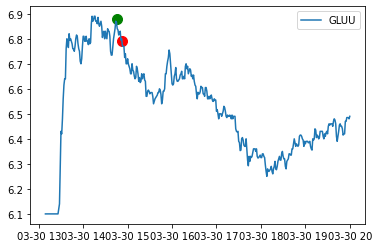

current_value=5.21 series = [5.     4.97   4.99   5.05   5.21   5.12   5.15   5.165  5.2    5.135
 5.0501 5.06   5.1288 5.1086 4.91   4.88   5.01   5.01   5.     4.9301
 4.89   4.9    4.9499 4.95   4.8899 4.87   4.85   4.8601 4.91   4.965
 4.95   4.98   4.94   4.9    4.94   5.02   4.97   4.9514 4.935  4.95
 4.8792 4.96   4.97   4.95   4.99   4.99   4.86   4.92   4.93   4.93
 4.94   4.93   4.93  ]
[]
{}
resistances=[]
current_value=5.21 series = [5.     4.97   4.99   5.05   5.21   5.12   5.15   5.165  5.2    5.135
 5.0501 5.06   5.1288 5.1086 4.91   4.88   5.01   5.01   5.     4.9301
 4.89   4.9    4.9499 4.95   4.8899 4.87   4.85   4.8601 4.91   4.965
 4.95   4.98   4.94   4.9    4.94   5.02   4.97   4.9514 4.935  4.95
 4.8792 4.96   4.97   4.95   4.99   4.99   4.86   4.92   4.93   4.93
 4.94   4.93   4.93  ]
[4.93, 4.94, 4.95, 4.95, 4.965, 4.97, 4.98, 4.99, 4.99, 5.01, 5.01, 5.02, 5.1288, 5.2, 5.21]
{1: [4.93, 4.94, 4.95, 4.95, 4.965, 4.97, 4.98, 4.99, 4.99, 5.01, 5.01, 5.02], 2: [5.1

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1552.58,-1552.58,buy,2020-03-30 14:16:33.489358,5.21,"[4.98, 5.2]",[],298,"{'rsi': 75.45774647882095, 'macd': [0.04078123722282623, 0.04890004069616527, 0.05709682358044965, 0.06446357001593839, 0.07029833067034197], 'sell_macd': [0.02070384666027625, 0.0261836234233348, 0.0316719738435971, 0.03657624723803998, 0.040442223295554136], 'slow macd': [0.0919351035900009, 0.09279381782029539, 0.09391525971258918, 0.09511668984266386, 0.09622985416490781], 'macd_signal': [0.04533893541524708, 0.04605115647143072, 0.048260289893234505, 0.05150094591777528, 0.05526042286828862], 'sell_macd_signal': [0.022856280334278452, 0.02352174895208972, 0.025151793930391197, 0.027436684591920953, 0.03003779233264759]}",6.02,4.94
1,-47.68,1504.90,sell,2020-03-30 14:45:19.310627,5.05,None,None,298,"{'rsi': 43.08779936903142, 'reasons': 'below cost & macd negative', 'movement': -0.02303262955854129, 'sell_macd': [0.014384564925700616, 0.010575076431674546, 0.006949824664489235, 0.0024762541359750756, -0.001041804121775236], 'sell_macd_signal': [0.019599362594360632, 0.017794505361823414, 0.015625569222356576, 0.012995706205080277, 0.010188204139709174]}",6.02,4.94


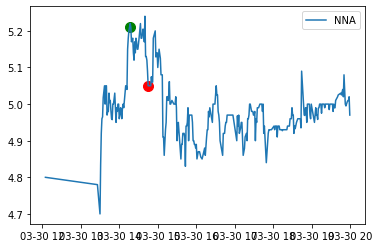

current_value=9.85 series = [ 9.84   9.85   9.89   9.91   9.92   9.935  9.935 10.01   9.97   9.98
  9.99   9.97   9.975  9.92   9.94   9.96   9.965  9.99  10.005  9.97
  9.945  9.95   9.94   9.94   9.94   9.91   9.905  9.92   9.94   9.925
  9.92   9.92   9.895  9.89   9.89   9.88   9.88   9.84   9.835  9.825
  9.83 ]
[9.88, 9.89, 9.92, 9.935, 9.94, 9.94, 9.94, 9.95, 9.975, 9.99, 10.005, 10.01]
{1: [9.88, 9.89, 9.92, 9.935, 9.94, 9.94, 9.94, 9.95, 9.975, 9.99, 10.005, 10.01]}
resistances=[9.95]
current_value=9.85 series = [ 9.84   9.85   9.89   9.91   9.92   9.935  9.935 10.01   9.97   9.98
  9.99   9.97   9.975  9.92   9.94   9.96   9.965  9.99  10.005  9.97
  9.945  9.95   9.94   9.94   9.94   9.91   9.905  9.92   9.94   9.925
  9.92   9.92   9.895  9.89   9.89   9.88   9.88   9.84   9.835  9.825
  9.83 ]
[]
{}
supports=[]
WBK analysis for run 122 with profit 127.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6619.20,-6619.20,buy,2020-03-30 14:20:28.214745,9.85,[],[9.95],672,"{'rsi': 67.79715349329894, 'macd': [0.029433002266014086, 0.03251404724110074, 0.03435801071456268, 0.03481287656169485, 0.036367966595069134], 'sell_macd': [0.015107243588801111, 0.0172460710048572, 0.018558844692631027, 0.018951150881900247, 0.02004968621273484], 'slow macd': [0.061121025268649376, 0.061332425251304556, 0.06138884334770012, 0.06122261490564185, 0.061291634455903576], 'macd_signal': [0.030998271474901216, 0.03130142662814112, 0.03191274344542543, 0.032492770068679316, 0.03326780937395728], 'sell_macd_signal': [0.015511172690090806, 0.015858152353044084, 0.016398290820961472, 0.016908862833149227, 0.01753702750906635]}",10.22,9.74
1,127.68,6746.88,sell,2020-03-30 15:31:06.463505,10.04,None,None,672,"{'rsi': 78.4297997996411, 'reasons': 'rsi max', 'movement': 0.01926977687626788, 'sell_macd': [0.008646856970996097, 0.00934328551512742, 0.011323057296072747, 0.012718683913742979, 0.016757890577983048], 'sell_macd_signal': [0.010682077897044237, 0.010414319420660874, 0.01059606699574325, 0.011020590379343196, 0.012168050419071166]}",10.22,9.74


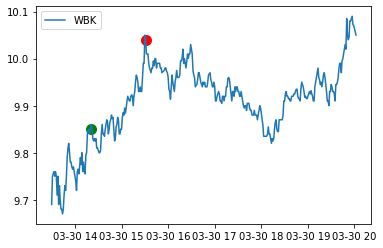

current_value=5.1 series = [4.97   4.97   4.97   4.8899 4.8    4.81   4.83   4.75   4.75   4.75
 4.79   4.79   4.74   4.61   4.53   4.5    4.4299 4.48   4.53   4.4591
 4.4799 4.4599 4.4388 4.42   4.41   4.4199 4.41   4.29   4.2199 4.26
 4.33   4.35   4.3    4.21   4.21   4.15   4.03   4.02   4.06   4.07
 4.0799]
[]
{}
resistances=[]
current_value=5.1 series = [4.97   4.97   4.97   4.8899 4.8    4.81   4.83   4.75   4.75   4.75
 4.79   4.79   4.74   4.61   4.53   4.5    4.4299 4.48   4.53   4.4591
 4.4799 4.4599 4.4388 4.42   4.41   4.4199 4.41   4.29   4.2199 4.26
 4.33   4.35   4.3    4.21   4.21   4.15   4.03   4.02   4.06   4.07
 4.0799]
[4.21, 4.35, 4.4199, 4.4799, 4.53, 4.75, 4.79, 4.79, 4.83, 4.97, 4.97]
{1: [4.21], 2: [4.35], 3: [4.4199], 4: [4.4799], 5: [4.53], 6: [4.75, 4.79, 4.79, 4.83], 7: [4.97, 4.97]}
supports=[4.79, 4.97]
JNUG analysis for run 122 with profit -29.28


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1866.60,-1866.60,buy,2020-03-30 14:23:02.544518,5.10,"[4.79, 4.97]",[],366,"{'rsi': 63.585666078516226, 'macd': [0.04043214050134036, 0.041737105413165665, 0.043073620880685226, 0.043629880909303864, 0.04517190935441118], 'sell_macd': [0.021332476331762606, 0.022302925742462065, 0.0232837574164817, 0.02374565537784079, 0.024841346576589984], 'slow macd': [0.06715450678435442, 0.06730372861424527, 0.06749171122764963, 0.06755671768447957, 0.0678299495862893], 'macd_signal': [0.046174596826528344, 0.045287098543855805, 0.04484440301122169, 0.044601498590838125, 0.04471558074355274], 'sell_macd_signal': [0.024674995771997554, 0.024200581766090457, 0.024017216896168706, 0.023962904592503123, 0.024138592989320494]}",5.77,4.89
1,-29.28,1837.32,sell,2020-03-30 14:41:13.190048,5.02,None,None,366,"{'rsi': 40.725860433195606, 'reasons': 'below cost & macd negative', 'movement': -0.017612524461839675, 'sell_macd': [0.011227233840507722, 0.009925600721390815, 0.0077486710088150446, 0.0038738079729263575, -0.00023483605468666013], 'sell_macd_signal': [0.017583433560220553, 0.016051866992454606, 0.014391227795726694, 0.012287743831166627, 0.00978322785399597]}",5.77,4.89


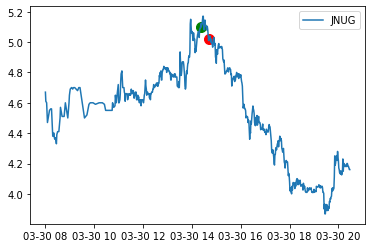

current_value=16.55 series = [16.07   16.09   16.14   16.11   16.29   16.4    16.3602 16.32   16.54
 16.5335 16.76   16.8    16.66   16.7    16.72   16.8594 16.91   16.86
 16.88   16.9    16.8    16.8    16.85   16.94   16.97   16.95   17.0844
 17.41   17.6824 17.4    17.6    17.53   17.62   17.6    17.62   17.59
 17.75   17.64   17.57   17.52   17.4301 17.36   17.35   17.29   17.09
 17.24   17.23   17.16   17.025  17.015  17.05   17.02   17.01  ]
[16.8, 16.9, 16.91, 16.97, 17.05, 17.24, 17.6, 17.62, 17.62, 17.6824, 17.75]
{1: [16.8, 16.9, 16.91, 16.97, 17.05], 2: [17.24], 3: [17.6, 17.62, 17.62, 17.6824, 17.75]}
resistances=[16.93, 17.65]
current_value=16.55 series = [16.07   16.09   16.14   16.11   16.29   16.4    16.3602 16.32   16.54
 16.5335 16.76   16.8    16.66   16.7    16.72   16.8594 16.91   16.86
 16.88   16.9    16.8    16.8    16.85   16.94   16.97   16.95   17.0844
 17.41   17.6824 17.4    17.6    17.53   17.62   17.6    17.62   17.59
 17.75   17.64   17.57   17.52   17.4

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2250.80,-2250.80,buy,2020-03-30 14:49:39.952263,16.55,[16.47],"[16.93, 17.65]",136,"{'rsi': 74.26790102544022, 'macd': [0.04374760482242834, 0.05234027042566325, 0.060486201933318995, 0.06578018015802556, 0.08712697016133575], 'sell_macd': [0.026660424944168426, 0.03220191940249251, 0.03741085119595766, 0.04072416361689335, 0.05446539194986855], 'slow macd': [0.06155369599103011, 0.06318179738459051, 0.06498169107393537, 0.06645375369484086, 0.07130037547649692], 'macd_signal': [0.022050512949630056, 0.028108464444836695, 0.034584011942533154, 0.040823245585631635, 0.05008399050077246], 'sell_macd_signal': [0.012106111407132613, 0.01612527300620459, 0.020382388644155206, 0.024450743638702834, 0.030453673300935978]}",18.35,15.99
1,42.16,2292.96,sell,2020-03-30 15:38:31.987975,16.86,None,None,136,"{'rsi': 60.43586588497112, 'reasons': 'bail', 'movement': 0.02050663449939707, 'sell_macd': [0.03622116409565024, 0.034169116363486296, 0.027679610125908027, 0.025380259679408823, 0.03364855466032424], 'sell_macd_signal': [0.044880474144070384, 0.042738202587953564, 0.039726484095544454, 0.03685723921231733, 0.03621550230191871]}",18.35,15.99


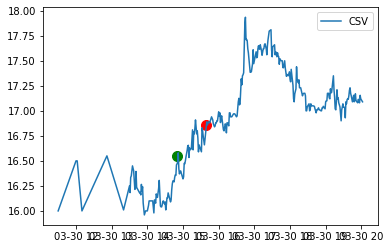

current_value=6.28 series = [6.2   6.18  6.16  6.18  6.2   6.19  6.16  6.14  6.15  6.165 6.16  6.22
 6.21  6.185 6.215 6.19  6.165 6.18  6.18  6.16  6.19  6.2   6.245 6.255
 6.305 6.31  6.36  6.24  6.205 6.21  6.23  6.245 6.23  6.25  6.235 6.23
 6.24  6.295 6.31  6.27  6.26 ]
[6.31, 6.36]
{1: [6.31, 6.36]}
resistances=[6.34]
current_value=6.28 series = [6.2   6.18  6.16  6.18  6.2   6.19  6.16  6.14  6.15  6.165 6.16  6.22
 6.21  6.185 6.215 6.19  6.165 6.18  6.18  6.16  6.19  6.2   6.245 6.255
 6.305 6.31  6.36  6.24  6.205 6.21  6.23  6.245 6.23  6.25  6.235 6.23
 6.24  6.295 6.31  6.27  6.26 ]
[6.165, 6.18, 6.18, 6.2, 6.215, 6.22, 6.245, 6.25]
{1: [6.165, 6.18, 6.18, 6.2, 6.215, 6.22, 6.245, 6.25]}
supports=[6.21]
SPWH analysis for run 124 with profit -5966.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5966.0,-5966.0,buy,2020-03-30 19:24:37.617667,6.28,[6.21],[6.34],950,"{'rsi': 57.906375861921035, 'macd': [-0.006129314517450801, -0.004878642161589397, 0.00014543039256587065, 0.004080012246761022, 0.005520724386124165], 'sell_macd': [-0.0035121054024322973, -0.00268694659722879, 0.0005883322976982797, 0.003132856991178379, 0.004035956012186759], 'slow macd': [0.00053832280819055, 0.0005253814194974282, 0.0013123147817282188, 0.0020342197826739294, 0.0023752699738155414], 'macd_signal': [-0.008089184422326211, -0.007447075970178849, -0.005928574697629905, -0.003926857308751719, -0.0020373409697765424], 'sell_macd_signal': [-0.004960940719008856, -0.004506141894652843, -0.003487247056182618, -0.0021632262467104185, -0.000923389794930983]}",6.55,6.21


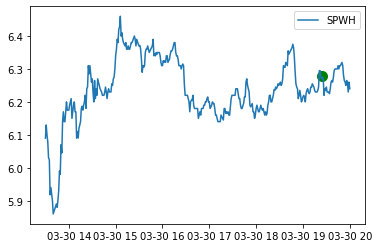

current_value=11.74 series = [11.54  11.64  11.62  11.62  11.69  11.685 11.635 11.64  11.68  11.69
 11.66  11.62  11.47  11.52  11.52  11.56  11.515 11.43  11.44  11.46
 11.37  11.45  11.41  11.49  11.58  11.59  11.6   11.59  11.62  11.62
 11.64  11.68  11.72  11.74  11.71  11.63  11.625 11.675 11.6   11.62
 11.52  11.57 ]
[]
{}
resistances=[]
current_value=11.74 series = [11.54  11.64  11.62  11.62  11.69  11.685 11.635 11.64  11.68  11.69
 11.66  11.62  11.47  11.52  11.52  11.56  11.515 11.43  11.44  11.46
 11.37  11.45  11.41  11.49  11.58  11.59  11.6   11.59  11.62  11.62
 11.64  11.68  11.72  11.74  11.71  11.63  11.625 11.675 11.6   11.62
 11.52  11.57 ]
[11.45, 11.46, 11.52, 11.56, 11.6, 11.62, 11.62, 11.64, 11.675, 11.69, 11.69, 11.74]
{1: [11.45, 11.46, 11.52, 11.56, 11.6, 11.62, 11.62, 11.64, 11.675, 11.69, 11.69, 11.74]}
supports=[11.61]
INVA analysis for run 124 with profit -5259.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5259.52,-5259.52,buy,2020-03-30 19:12:04.583665,11.74,[11.61],[],448,"{'rsi': 69.27075973075104, 'macd': [0.0264127381594097, 0.027224863751504458, 0.029944052021646073, 0.03173322742393303, 0.03516653319582197], 'sell_macd': [0.01538676531072447, 0.01590015489225216, 0.017652144762374533, 0.01878808304088153, 0.020987670231393807], 'slow macd': [0.016740742181170276, 0.01750185063816012, 0.018653911076775387, 0.01968400920750213, 0.021080058692497516], 'macd_signal': [0.023770118410447093, 0.024461067478658567, 0.025557664387256068, 0.026792776994591462, 0.028467528234837565], 'sell_macd_signal': [0.013689797400967516, 0.014131868899224445, 0.014835924071854464, 0.01562635586565988, 0.016698618738806664]}",12.29,11.57


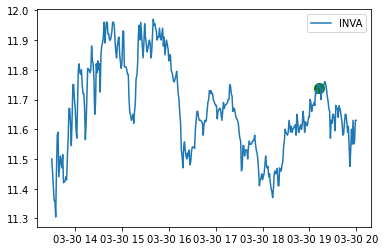

current_value=4.59 series = [4.585  4.54   4.52   4.53   4.56   4.565  4.52   4.53   4.53   4.53
 4.54   4.55   4.55   4.535  4.48   4.48   4.47   4.47   4.47   4.46
 4.46   4.44   4.48   4.49   4.48   4.46   4.475  4.495  4.505  4.5
 4.51   4.565  4.5799 4.6    4.565  4.575  4.58   4.59   4.585  4.65
 4.66   4.67  ]
[4.6]
{1: [4.6]}
resistances=[]
current_value=4.59 series = [4.585  4.54   4.52   4.53   4.56   4.565  4.52   4.53   4.53   4.53
 4.54   4.55   4.55   4.535  4.48   4.48   4.47   4.47   4.47   4.46
 4.46   4.44   4.48   4.49   4.48   4.46   4.475  4.495  4.505  4.5
 4.51   4.565  4.5799 4.6    4.565  4.575  4.58   4.59   4.585  4.65
 4.66   4.67  ]
[4.46, 4.47, 4.47, 4.48, 4.49, 4.505, 4.53, 4.53, 4.55, 4.55, 4.565, 4.59]
{1: [4.46, 4.47, 4.47, 4.48, 4.49, 4.505, 4.53, 4.53, 4.55, 4.55, 4.565, 4.59]}
supports=[4.52]
current_value=4.59 series = [4.585  4.54   4.52   4.53   4.56   4.565  4.52   4.53   4.53   4.53
 4.54   4.55   4.55   4.535  4.48   4.48   4.47   4.47   4.47 

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3704.13,-3704.13,buy,2020-03-30 19:14:08.675689,4.59,[4.52],[],807,"{'rsi': 78.61728488320392, 'macd': [0.00880681635300018, 0.011475052846236622, 0.015827944083429912, 0.019456813923585337, 0.022477075890390275], 'sell_macd': [0.005425924281760253, 0.00713702268911387, 0.009936099075504856, 0.01224789757041389, 0.014149975649947244], 'slow macd': [0.0008768732304309523, 0.0017248533649016906, 0.0029820716279793658, 0.004213951250862102, 0.00542054829494365], 'macd_signal': [0.00712030329801768, 0.007991253207661468, 0.009558591382815156, 0.011538235890969192, 0.013726003890853409], 'sell_macd_signal': [0.004425681582225052, 0.0049679498036028155, 0.005961579657983223, 0.007218843240469357, 0.008605069722364935]}",4.89,4.49
1,-8.07,3696.06,sell,2020-03-30 19:14:23.340813,4.58,None,None,807,"{'rsi': 78.61728488320392, 'reasons': 'rsi max', 'movement': 0.0, 'sell_macd': [0.005425924281760253, 0.00713702268911387, 0.009936099075504856, 0.01224789757041389, 0.014149975649947244], 'sell_macd_signal': [0.004425681582225052, 0.0049679498036028155, 0.005961579657983223, 0.007218843240469357, 0.008605069722364935]}",4.89,4.49
2,-3537.78,-3529.71,buy,2020-03-30 19:14:27.473669,4.59,[4.52],[],769,"{'rsi': 79.39080074105604, 'macd': [0.00880681635300018, 0.011475052846236622, 0.015827944083429912, 0.019456813923585337, 0.022875936289250554], 'sell_macd': [0.005425924281760253, 0.00713702268911387, 0.009936099075504856, 0.01224789757041389, 0.014409715909687648], 'slow macd': [0.0008768732304309523, 0.0017248533649016906, 0.0029820716279793658, 0.004213951250862102, 0.005500516307739289], 'macd_signal': [0.00712030329801768, 0.007991253207661468, 0.009558591382815156, 0.011538235890969192, 0.013805775970625465], 'sell_macd_signal': [0.004425681582225052, 0.0049679498036028155, 0.005961579657983223, 0.007218843240469357, 0.008657017774313016]}",4.91,4.49
3,-8.07,3529.71,sell,2020-03-30 19:14:58.997060,4.59,None,None,769,"{'rsi': 78.61728488320392, 'reasons': 'rsi max', 'movement': -0.0010881392818280508, 'sell_macd': [0.005425924281760253, 0.00713702268911387, 0.009936099075504856, 0.01224789757041389, 0.014149975649947244], 'sell_macd_signal': [0.004425681582225052, 0.0049679498036028155, 0.005961579657983223, 0.007218843240469357, 0.008605069722364935]}",4.91,4.49
4,-3384.47,-3376.40,buy,2020-03-30 19:18:21.245700,4.60,[4.52],[],734,"{'rsi': 78.26679751432356, 'macd': [0.019456813923585337, 0.022477075890390275, 0.02458722898813903, 0.025561426099045548, 0.027229968837231944], 'sell_macd': [0.01224789757041389, 0.014149975649947244, 0.015448348495688435, 0.015999699433984382, 0.01700075601663098], 'slow macd': [0.004213951250862102, 0.00542054829494365, 0.006521986761658383, 0.0074449463637629165, 0.008522095607660596], 'macd_signal': [0.011538235890969192, 0.013726003890853409, 0.015898248910310532, 0.017830884348057536, 0.019710701245892418], 'sell_macd_signal': [0.007218843240469357, 0.008605069722364935, 0.009973725477029636, 0.011178920268420585, 0.012343287418062664]}",4.93,4.49
5,-22.75,3361.72,sell,2020-03-30 19:18:24.805728,4.58,None,None,734,"{'rsi': 79.91792472860769, 'reasons': 'rsi max', 'movement': 0.0010869565217393005, 'sell_macd': [0.014149975649947244, 0.015448348495688435, 0.015999699433984382, 0.017260496276370496, 0.018278513344770708], 'sell_macd_signal': [0.008605069722364935, 0.009973725477029636, 0.011178920268420585, 0.012395235470010566, 0.013571891044962595]}",4.93,4.49
6,-3105.09,-3082.34,buy,2020-03-30 19:19:05.846322,4.58,[4.51],[4.6],673,"{'rsi': 79.91792472860769, 'macd': [0.022477075890390275, 0.02458722898813903, 0.025561426099045548, 0.027628829236091335, 0.029332591474676484], 'sell_macd': [0.014149975649947244, 0.015448348495688435, 0.015999699433984382, 0.017260496276370496, 0.018278513344770708], 'slow macd': [0.00542054829494365, 0.006521986761658383, 0.0074449463637629165, 0.008602063620455347, 0.00973285

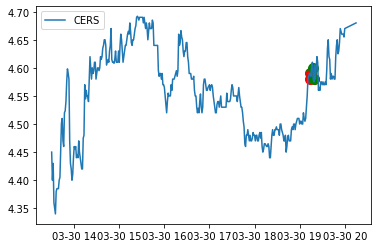

current_value=14.36 series = [14.2399 14.1399 14.14   14.13   14.175  14.2    14.23   14.315  14.35
 14.3508 14.26   14.25   14.24   14.17   14.1    14.16   14.15   14.1
 14.11   14.16   14.304  14.32   14.38   14.38   14.25   14.23   14.295
 14.35   14.27   14.2372 14.21   14.2    14.275  14.27   14.25   14.25
 14.28   14.2301 14.     14.     14.3    14.08   14.06  ]
[14.38, 14.38]
{1: [14.38, 14.38]}
resistances=[14.38]
current_value=14.36 series = [14.2399 14.1399 14.14   14.13   14.175  14.2    14.23   14.315  14.35
 14.3508 14.26   14.25   14.24   14.17   14.1    14.16   14.15   14.1
 14.11   14.16   14.304  14.32   14.38   14.38   14.25   14.23   14.295
 14.35   14.27   14.2372 14.21   14.2    14.275  14.27   14.25   14.25
 14.28   14.2301 14.     14.     14.3    14.08   14.06  ]
[14.14, 14.16, 14.275, 14.28, 14.3, 14.35, 14.3508]
{1: [14.14, 14.16, 14.275, 14.28, 14.3, 14.35, 14.3508]}
supports=[14.27]
NVAX analysis for run 124 with profit -48.36


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5787.08,-5787.08,buy,2020-03-30 19:11:26.515423,14.36,[14.27],[14.38],403,"{'rsi': 58.89670104099455, 'macd': [-0.007775696412803512, -0.002468112969054914, -0.0006827628297187971, 0.002726075744744705, 0.007360053821663826], 'sell_macd': [-0.007002784571410459, -0.003380237966114308, -0.0020772115468439267, 0.00026900659215733924, 0.0033924362252477636], 'slow macd': [0.016223017001365747, 0.01667613163508186, 0.016584933012786962, 0.01687594150460825, 0.017516527979484664], 'macd_signal': [0.0014730719905210621, 0.0006848349986058669, 0.00041131543294093407, 0.0008742674953016882, 0.0021714247605741158], 'sell_macd_signal': [-0.0013878085053562663, -0.0017862943975078746, -0.001844477827375085, -0.0014217809434686002, -0.00045893750972532746]}",14.96,14.16
1,-48.36,5738.72,sell,2020-03-30 19:19:21.548416,14.24,None,None,403,"{'rsi': 42.72855981921481, 'reasons': 'below cost & macd negative', 'movement': -0.00696378830083563, 'sell_macd': [0.005574480187860331, 0.005659146739809273, 0.0038230538356174293, 0.0026128119124084748, -0.000442088442202504], 'sell_macd_signal': [0.0028678404176088793, 0.003426101682048958, 0.0035054921127626523, 0.003326956072691817, 0.0025731471697129525]}",14.96,14.16


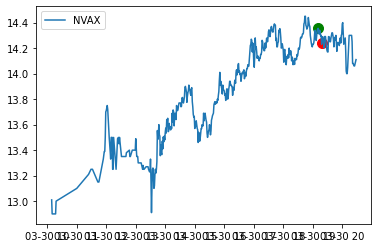

current_value=19.05 series = [18.87  18.79  18.85  18.94  19.04  19.05  19.03  19.01  19.    19.079
 19.08  19.075 19.09  19.06  19.08  19.035 19.02  19.02  19.025 19.05
 19.025 18.98  18.92  18.92  18.965 18.98  18.985 19.01  19.04  19.05
 19.01  19.02  19.04  19.12  19.06  19.09  19.015 19.005 18.98  19.06
 19.07  19.13  19.   ]
[19.08, 19.08, 19.09, 19.09, 19.12, 19.13]
{1: [19.08, 19.08, 19.09, 19.09, 19.12, 19.13]}
resistances=[19.1]
current_value=19.05 series = [18.87  18.79  18.85  18.94  19.04  19.05  19.03  19.01  19.    19.079
 19.08  19.075 19.09  19.06  19.08  19.035 19.02  19.02  19.025 19.05
 19.025 18.98  18.92  18.92  18.965 18.98  18.985 19.01  19.04  19.05
 19.01  19.02  19.04  19.12  19.06  19.09  19.015 19.005 18.98  19.06
 19.07  19.13  19.   ]
[19.05, 19.05, 19.05]
{1: [19.05, 19.05, 19.05]}
supports=[19.05]
SNDR analysis for run 124 with profit -21983.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-21983.7,-21983.7,buy,2020-03-30 19:18:22.437023,19.05,[19.05],[19.1],1154,"{'rsi': 67.54239190245991, 'macd': [0.001558418139634199, 0.003622375886340734, 0.009585620549586338, 0.014547300892019166, 0.019864317674358034], 'sell_macd': [0.0003758078115687624, 0.001747971453752939, 0.005651631805402957, 0.008879787510515769, 0.012318872637742118], 'slow macd': [0.004674624288078633, 0.005048255823073333, 0.006263582947713786, 0.007451673064469588, 0.00885270811700778], 'macd_signal': [0.004703544344947225, 0.004487310653225927, 0.005506972632498009, 0.007315038284402241, 0.0098248941623934], 'sell_macd_signal': [0.0024219227860460485, 0.002287132519587427, 0.0029600323767505327, 0.00414398340350358, 0.0057789612503512874]}",19.26,18.98


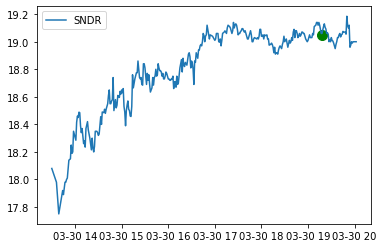

current_value=14.84 series = [14.7    14.695  14.745  14.84   14.94   14.93   14.885  14.93   14.895
 14.895  14.86   14.825  14.78   14.83   14.85   14.815  14.775  14.74
 14.7    14.66   14.7099 14.72   14.67   14.66   14.675  14.67   14.69
 14.69   14.7    14.73   14.755  14.755  14.775  14.81   14.82   14.87
 14.83   14.87   14.91   14.98   14.98  ]
[14.85, 14.87, 14.895, 14.93, 14.94, 14.98]
{1: [14.85, 14.87, 14.895, 14.93, 14.94, 14.98]}
resistances=[14.91]
current_value=14.84 series = [14.7    14.695  14.745  14.84   14.94   14.93   14.885  14.93   14.895
 14.895  14.86   14.825  14.78   14.83   14.85   14.815  14.775  14.74
 14.7    14.66   14.7099 14.72   14.67   14.66   14.675  14.67   14.69
 14.69   14.7    14.73   14.755  14.755  14.775  14.81   14.82   14.87
 14.83   14.87   14.91   14.98   14.98  ]
[14.675, 14.69, 14.72, 14.755]
{1: [14.675, 14.69, 14.72, 14.755]}
supports=[14.71]
VIPS analysis for run 124 with profit -8562.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8562.68,-8562.68,buy,2020-03-30 19:24:12.535257,14.84,[14.71],[14.91],577,"{'rsi': 76.43228708741132, 'macd': [0.015407495410086014, 0.01551330150443242, 0.0181396361765902, 0.022056683157037682, 0.026070817592920292], 'sell_macd': [0.009539321488288621, 0.009549031300119637, 0.011204012565181998, 0.013693556244902538, 0.016234842797349103], 'slow macd': [-0.0004190039852858263, 0.0001981079832322763, 0.0013109357351837048, 0.002746910510991185, 0.004303563976442604], 'macd_signal': [0.015236673386372473, 0.015291999009984462, 0.01586152644330561, 0.017100557786052024, 0.018894609747425677], 'sell_macd_signal': [0.009729798909612286, 0.009693645387713756, 0.009995718823207404, 0.010735286307546431, 0.011835197605506966]}",15.29,14.73


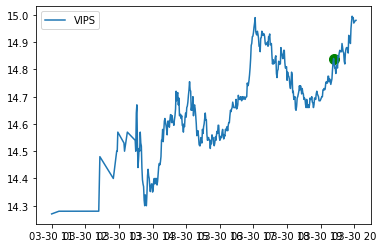

current_value=9.7 series = [9.71   9.77   9.82   9.83   9.84   9.8    9.8205 9.84   9.86   9.87
 9.885  9.88   9.85   9.82   9.74   9.7    9.69   9.64   9.58   9.62
 9.58   9.585  9.65   9.67   9.68   9.665  9.67   9.645  9.625  9.63
 9.675  9.695  9.7    9.65   9.615  9.59   9.595  9.585  9.6    9.665 ]
[9.84, 9.885]
{1: [9.84, 9.885]}
resistances=[9.86]
current_value=9.7 series = [9.71   9.77   9.82   9.83   9.84   9.8    9.8205 9.84   9.86   9.87
 9.885  9.88   9.85   9.82   9.74   9.7    9.69   9.64   9.58   9.62
 9.58   9.585  9.65   9.67   9.68   9.665  9.67   9.645  9.625  9.63
 9.675  9.695  9.7    9.65   9.615  9.59   9.595  9.585  9.6    9.665 ]
[9.595, 9.62, 9.67, 9.68, 9.7]
{1: [9.595, 9.62, 9.67, 9.68, 9.7]}
supports=[9.65]
FOLD analysis for run 124 with profit -4607.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4607.5,-4607.5,buy,2020-03-30 19:22:46.129806,9.7,[9.65],[9.86],475,"{'rsi': 70.2872857860693, 'macd': [0.012609572944604963, 0.013610604799483284, 0.014638642807726754, 0.01806928634344196, 0.02134891548004525], 'sell_macd': [0.008201327383275725, 0.00879368839387773, 0.009400804916506189, 0.01156997616898714, 0.013629460571323193], 'slow macd': [-0.004134962276365783, -0.0033638979125729662, -0.002569145936270445, -0.0012740636167105635, 7.942725565079911e-05], 'macd_signal': [0.006972641010460778, 0.008300233768265278, 0.009567915576157573, 0.01126818972961445, 0.01328433487970061], 'sell_macd_signal': [0.004646742367291966, 0.0054761315726091185, 0.0062610662413885325, 0.007322848226908254, 0.008584170695791243]}",10.26,9.58


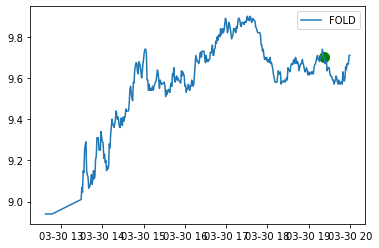

current_value=4.79 series = [4.9684 4.95   4.905  4.865  4.825  4.8257 4.82   4.79   4.76   4.77
 4.81   4.775  4.71   4.71   4.685  4.68   4.67   4.64   4.66   4.69
 4.72   4.7646 4.67   4.675  4.65   4.6566 4.66   4.6545 4.65   4.6679
 4.67   4.715  4.765  4.753  4.78   4.73   4.74   4.73   4.73   4.73
 4.735  4.73   4.74   4.73   4.76  ]
[4.81, 4.8257]
{1: [4.81, 4.8257]}
resistances=[4.82]
current_value=4.79 series = [4.9684 4.95   4.905  4.865  4.825  4.8257 4.82   4.79   4.76   4.77
 4.81   4.775  4.71   4.71   4.685  4.68   4.67   4.64   4.66   4.69
 4.72   4.7646 4.67   4.675  4.65   4.6566 4.66   4.6545 4.65   4.6679
 4.67   4.715  4.765  4.753  4.78   4.73   4.74   4.73   4.73   4.73
 4.735  4.73   4.74   4.73   4.76  ]
[4.66, 4.675, 4.71, 4.73, 4.735, 4.74, 4.74, 4.7646, 4.765, 4.78]
{1: [4.66, 4.675, 4.71, 4.73, 4.735, 4.74, 4.74, 4.7646, 4.765, 4.78]}
supports=[4.73]
STML analysis for run 124 with profit -2577.02


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2577.02,-2577.02,buy,2020-03-30 19:11:29.119323,4.79,[4.73],[4.82],538,"{'rsi': 67.74820893895998, 'macd': [0.026612881916737052, 0.026672546337439762, 0.02561761052645295, 0.02689231767708744, 0.027584554701920005], 'sell_macd': [0.01699382243369918, 0.016916355486050527, 0.016116818182869252, 0.016842934333859638, 0.01718999971990609], 'slow macd': [0.0016284002992446034, 0.002568327147567828, 0.00326904620770474, 0.004388309851265149, 0.005411049717089611], 'macd_signal': [0.01875753848408269, 0.020340540054754105, 0.021395954149093874, 0.022495226854692588, 0.02351309242413807], 'sell_macd_signal': [0.012232637711714947, 0.013169381266582063, 0.0137588686498395, 0.014375681786643528, 0.014938545373296041]}",5.24,4.64


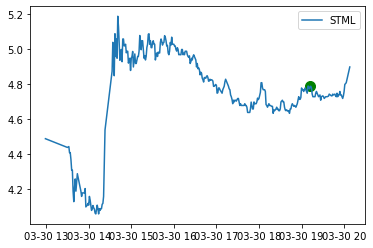

current_value=16.23 series = [15.15   15.31       nan 15.49   15.31   15.43   15.37       nan 15.5
 15.5    15.48   15.18   15.04   14.95   15.36   15.45   15.42   15.28
 15.5    15.59   15.46   15.555  15.58   15.57   15.5625 15.48   15.57
 15.71   15.665  15.61   15.75   15.73   15.72   15.85   16.46   16.34
 16.24   16.14   16.05   15.93   15.89   16.03   15.94   15.955  15.925
 15.92   16.08   16.3    16.23   16.09   15.95   15.9    15.965  16.21
 16.23   16.02   15.99   16.03   16.08   16.115  16.27   16.325  16.33
 16.4   ]
[16.3, 16.46]
{1: [16.3, 16.46]}
resistances=[16.38]
current_value=16.23 series = [15.15   15.31       nan 15.49   15.31   15.43   15.37       nan 15.5
 15.5    15.48   15.18   15.04   14.95   15.36   15.45   15.42   15.28
 15.5    15.59   15.46   15.555  15.58   15.57   15.5625 15.48   15.57
 15.71   15.665  15.61   15.75   15.73   15.72   15.85   16.46   16.34
 16.24   16.14   16.05   15.93   15.89   16.03   15.94   15.955  15.925
 15.92   16.08   16.3    16

<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-191-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3797.82,-3797.82,buy,2020-03-30 19:06:06.146104,16.23,"[15.57, 15.99]",[16.38],234,"{'rsi': 59.64418714611113, 'macd': [-0.0016675875332232692, -0.014085990726648845, -0.01846979960210504, -0.0077338116885492525, 0.007945196639035146], 'sell_macd': [-0.0024600878179050767, -0.01049303335746643, -0.013239574903128215, -0.006116885524384941, 0.004188026790536981], 'slow macd': [0.04257527280579332, 0.03890046191431473, 0.03649688666083506, 0.037026029321808096, 0.038893063766277436], 'macd_signal': [0.019153278558048555, 0.012505424701109075, 0.006310379840466251, 0.00350154153466315, 0.004390272555537549], 'sell_macd_signal': [0.011307316494304961, 0.006947246523950682, 0.0029098822385349027, 0.0011045286859509339, 0.0017212283068681433]}",17.27,15.88


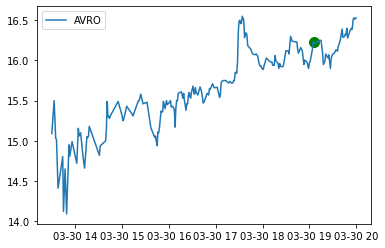

In [192]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

